# **CUSTOMER PROFILE FOR UNITED STATES CLYCING INDUSTRY USING K-MEANS AND RFM MODEL**

#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import squarify
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
import datetime as dt
from sklearn.metrics import silhouette_score
from plotly.subplots import make_subplots
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, boxcox
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


#### Loading dataset

In [2]:
# data
sales_df_raw = pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Sales_data')

date_df_raw = pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Date_data')

product_df_raw= pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Product_data')

customer_df_raw = pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Customer_data')

In [3]:
sales_df = sales_df_raw.drop(columns=['ResellerKey','DueDateKey','ShipDateKey','SalesTerritoryKey','Extended Amount','Unit Price Discount Pct','Product Standard Cost','Total Product Cost','Unit Price'])
sales_df.shape

(121253, 6)

In [4]:
product_df = product_df_raw.drop(columns=['SKU','Color','Standard Cost','List Price'])
product_df = product_df[product_df['Category'] == 'Bikes']
product_df.shape

(125, 5)

In [5]:
#keep columns DateKey, Date
date_df = date_df_raw.drop(columns=['Fiscal Year','Fiscal Quarter','Month','Full Date','MonthKey'])
date_df = date_df.rename(columns={'DateKey': 'OrderDateKey'})
date_df.shape

(1461, 2)

In [6]:

#delete value -1 of CustomerKey and columns Postal Code and Customer ID
customer_df_raw = customer_df_raw[customer_df_raw['CustomerKey'] != -1]
customer_df_raw = customer_df_raw[customer_df_raw['Country-Region'] == 'United States']
customer_df = customer_df_raw.drop(columns=['Postal Code','Customer ID'])

customer_df.shape

(7819, 5)

#### Data Engineering
create the dataframe for RFM model

In [7]:
aw_df = pd.merge(left=sales_df, right=product_df,on='ProductKey')
aw_df = pd.merge(left=aw_df, right=date_df, on='OrderDateKey')
aw_df = pd.merge(left=aw_df, right=customer_df, on='CustomerKey')

aw_df.head()

SalesOrderLineKey  CustomerKey  ProductKey  OrderDateKey  Order Quantity  \
0           43711001        27606         314      20170702               1   
1           71134001        27606         563      20200421               1   
2           43706001        27621         312      20170702               1   
3           71203001        27621         561      20200422               1   
4           43707001        27616         312      20170702               1   

   Sales Amount                  Product         Model    Subcategory  \
0       3578.27         Road-150 Red, 56      Road-150     Road Bikes   
1       2384.07  Touring-1000 Yellow, 54  Touring-1000  Touring Bikes   
2       3578.27         Road-150 Red, 48      Road-150     Road Bikes   
3       2384.07  Touring-1000 Yellow, 46  Touring-1000  Touring Bikes   
4       3578.27         Road-150 Red, 48      Road-150     Road Bikes   

  Category       Date          Customer          City State-Province  \
0    Bikes 2017-07-02  Courtney Edwards     Milwaukie         Oregon   
1    Bikes 2020-04-21  Courtney Edwards     Milwaukie         Oregon   
2    Bikes 2017-07-02      Edward Brown  Santa Monica     California   
3    Bikes 2020-04-22      Edward Brown  Santa Monica     California   
4    Bikes 2017-07-02        Emma Brown   Lemon Grove     California   

  Country-Region  
0  United States  
1  United States  
2  United States  
3  United States  
4  United States

#### Data Wrangling
Missing values analysis and Outliers dectection

In [8]:
#checking datatypes and null values

aw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4907 entries, 0 to 4906
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SalesOrderLineKey  4907 non-null   int64         
 1   CustomerKey        4907 non-null   int64         
 2   ProductKey         4907 non-null   int64         
 3   OrderDateKey       4907 non-null   int64         
 4   Order Quantity     4907 non-null   int64         
 5   Sales Amount       4907 non-null   float64       
 6   Product            4907 non-null   object        
 7   Model              4907 non-null   object        
 8   Subcategory        4907 non-null   object        
 9   Category           4907 non-null   object        
 10  Date               4907 non-null   datetime64[ns]
 11  Customer           4907 non-null   object        
 12  City               4907 non-null   object        
 13  State-Province     4907 non-null   object        
 14  Country-

Missing values analysis

In [9]:
#checking null values
aw_df.isnull().sum()

SalesOrderLineKey    0
CustomerKey          0
ProductKey           0
OrderDateKey         0
Order Quantity       0
Sales Amount         0
Product              0
Model                0
Subcategory          0
Category             0
Date                 0
Customer             0
City                 0
State-Province       0
Country-Region       0
dtype: int64

Observation
* Datatype of OrderDate is already datatime type
* There is no null values in dataframe

In [10]:
aw_df = aw_df.dropna()
aw_df.isnull().sum()

SalesOrderLineKey    0
CustomerKey          0
ProductKey           0
OrderDateKey         0
Order Quantity       0
Sales Amount         0
Product              0
Model                0
Subcategory          0
Category             0
Date                 0
Customer             0
City                 0
State-Province       0
Country-Region       0
dtype: int64

In [11]:
aw_df=aw_df.drop_duplicates()

Data descriptive statistics

In [12]:
aw_df.describe().style.background_gradient(cmap='YlGn')

* SalesOrderLineKey
 
max value: 74142 thousand 

min value: 436999 thousand

mean > standard deviation, the SalesOrderLineKey has positive skewness. In this research, this feature will be used for calculate the Recency value of RFM model.
* CustomerKey, ProductKey, and OrderDateKey: a key to call out needed data from each dataframe.
* Order Quantity
max = min = mean = std = 1
-> this value does not have an effect on the model result.
* Sales Amount 
This value = Order Quantity x Unit Price. (Order Quantity = 1) -> this study will use the Sales Amount feature to calculate the Monetary value of the RFM model.

* Date

This feature will be used to calculate Frequency value. Because in this dataframe this feature have a datetime type, so it has not been statistics described.


## Exploratory Data Analysis 

#### top 10 highest selling products

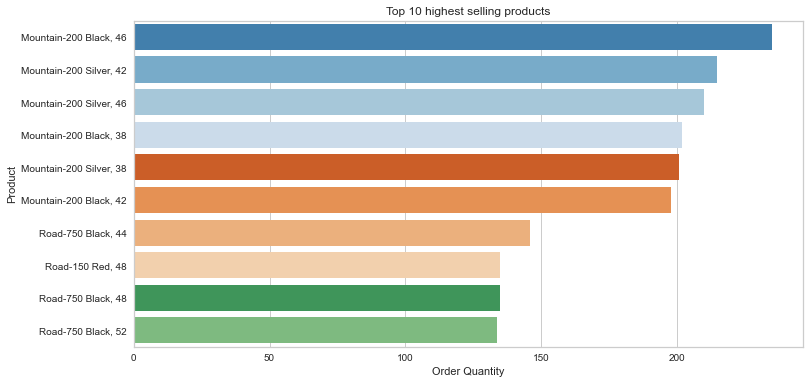

In [13]:
df1 = aw_df.groupby(['Product']).sum()
df1.sort_values(by='Order Quantity', ascending=False, inplace=True)
df1.reset_index(inplace=True)
df1 = df1[:10]
plt.figure(figsize=(12,6))
sns.barplot(x=df1['Order Quantity'],y=df1['Product'],palette=("tab20c"))
plt.title('Top 10 highest selling products')
plt.show()

#### top 10 least selling products

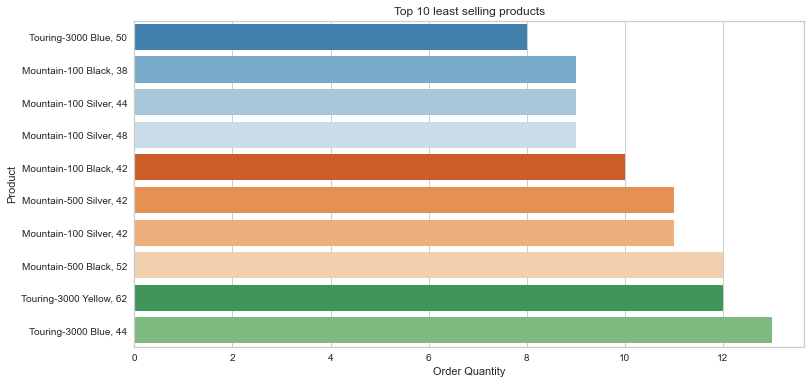

In [14]:
df2 = aw_df.groupby(['Product']).sum()
df2.sort_values(by='Order Quantity', ascending=True, inplace=True)
df2.reset_index(inplace=True)
df2 = df2[:10]
plt.figure(figsize=(12,6))
sns.barplot(x=df2['Order Quantity'],y=df2['Product'],palette=("tab20c"))
plt.title('Top 10 least selling products')
plt.show()

Date Time Analysis

In [15]:

datetime_df = aw_df.copy()
datetime_df['Month'] = datetime_df['Date'].dt.month
datetime_df['Year'] = datetime_df['Date'].dt.year
datetime_df['Day'] = datetime_df['Date'].dt.day
datetime_df['Day of Week'] = datetime_df['Date'].dt.day_of_week

In [16]:
# Add month column
sales_by_month = datetime_df.groupby('Month')['Sales Amount'].sum().reset_index().sort_values('Sales Amount', ascending=False)
sales_by_month.style.background_gradient(cmap='YlGn')

In [17]:
# Orders by day of the week
orderbydow = datetime_df.groupby(datetime_df["Date"].dt.day_name())["SalesOrderLineKey"].count().reset_index()
orderbydow.rename(columns={"SalesOrderLineKey":"Total Orders", "Date": "Weekday Name"}, inplace=True)
orderbydow = orderbydow.sort_values(by="Weekday Name", ascending=False)
orderbydow


Weekday Name  Total Orders
6    Wednesday           700
5      Tuesday           698
4     Thursday           692
3       Sunday           753
2     Saturday           705
1       Monday           700
0       Friday           659

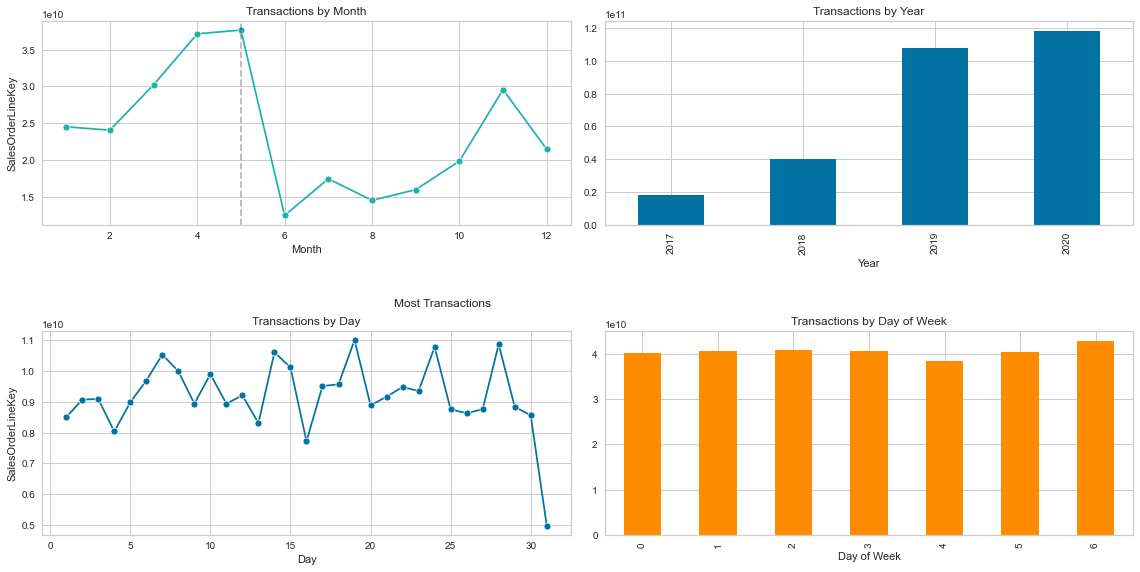

In [18]:
plt.figure(figsize=(16,12))

plt.subplot(3,2,1)
sns.lineplot(x = "Month", y = "SalesOrderLineKey", data = datetime_df.groupby("Month").sum("SalesOrderLineKey"), marker = "o", color = "lightseagreen")
plt.axvline(5, color = "k", linestyle = '--', alpha = 0.3)
plt.text(8.50, 1.3e6, "Most Transactions")
plt.title("Transactions by Month")

plt.subplot(3,2,2)
datetime_df.groupby("Year").sum()["SalesOrderLineKey"].plot(kind = "bar")
plt.title("Transactions by Year")

plt.subplot(3,2,3)
sns.lineplot(x = "Day", y = "SalesOrderLineKey", data = datetime_df.groupby("Day").sum("SalesOrderLineKey"), marker = "o", )
plt.title("Transactions by Day")

plt.subplot(3,2,4)
datetime_df.groupby("Day of Week").sum()["SalesOrderLineKey"].plot(kind = "bar", color = "darkorange")
plt.title("Transactions by Day of Week")

plt.tight_layout()
plt.show()

In [19]:
fig4 = make_subplots(rows=1, cols=1, shared_xaxes=True,
                    shared_yaxes=False, vertical_spacing=0.001)
fig4.append_trace(go.Bar(
    x=sales_by_month['Month'],
    y=sales_by_month['Sales Amount'],
    marker=dict(color='rgba(50, 171, 96, 0.6)',
                line=dict(
                color='rgba(50, 171, 96, 1.0)',
                width=1)
                )),1,1)
fig4.update_layout(title='Sales Amount in each month',
                font_color= '#193806',
                title_font_color='green', 
                font_size=18,
                width=1000, height=500
                )
fig4.update_xaxes(title='Month')
fig4.update_yaxes(title='Total Sales Amount')
fig4.show()

In [20]:
px.bar(aw_df[['Date','SalesOrderLineKey']].set_index('Date').resample('M').count().reset_index(),
       x='Date', y='SalesOrderLineKey', title = 'Number of sales order per month')

#### Revenue by State-Province

In [21]:
revenue_percent = aw_df.groupby('State-Province').sum()
revenue_percent.sort_values(['Sales Amount'], ascending=False, inplace=True)
revenue_percent.reset_index(inplace=True)
revenue_percent['Percentage of revenue'] = (revenue_percent['Sales Amount'] / revenue_percent['Sales Amount'].sum()) * 100
revenue_per_state = revenue_percent[['State-Province', 'Sales Amount', 'Percentage of revenue']]
revenue_per_state.style.background_gradient(cmap='YlGn')

#### Pie chart revenue by state

In [22]:
data = [revenue_per_state.iloc[0,2], revenue_per_state.iloc[1,2], revenue_per_state.iloc[2,2], (revenue_per_state['Percentage of revenue'].iloc[3:]).sum()]
label = 'Californina', 'Washington', 'Oregon', 'Others'
revenue = px.data.tips()
fig1 = px.pie(revenue, values=data, names=label, 
            color_discrete_sequence=px.colors.sequential.YlGn_r, 
            title='Revenue by State in the United States',
            width=500, height=500
            )
fig1.show()

#### Geographical chart about Revenue by State in the US

In [23]:
fig = go.Figure(data=go.Choropleth(
    locations=['CA','WA','OR','FL','WY','UT','NY','IL','SC','AZ','MA','GA','TX'],
    z = revenue_per_state['Sales Amount'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    marker_line_color='white',
    autocolorscale=False,
    colorbar_title = "Dollar"
))

fig.update_layout(
    title_text = 'Revenue by State in United States',
    geo_scope='usa', # limite map scope to USA
)
fig.update_layout(font_color= '#260641',
                title_font_color='#6F0A0E',
                font_size=18,
                width=700,
                height=500
)
fig.show()      

## RFM analysis

In [24]:
recent_day = aw_df['Date'].max()
recent_day

Timestamp('2020-05-30 00:00:00')

calculate RFM values

In [25]:
df_rfm = aw_df.groupby(by='CustomerKey', as_index=False).agg(
    {
        'Date': lambda r: (recent_day - r.max()).days,
        'SalesOrderLineKey': lambda f: f.nunique(),
        'Sales Amount': lambda m: m.sum()
    }
)

df_rfm.columns = ['Customer ID','Recency','Frequency','Monetary']
df_rfm.head().style.background_gradient(cmap='YlGn')

In [26]:
df_rfm['Recency'].describe()


count    3569.000000
mean      204.569627
std       212.433617
min         0.000000
25%        67.000000
50%       159.000000
75%       260.000000
max      1062.000000
Name: Recency, dtype: float64

In [27]:
df_rfm['Frequency'].describe()

count    3569.000000
mean        1.374895
std         0.489918
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: Frequency, dtype: float64

In [28]:
df_rfm['Monetary'].describe()

count    3569.000000
mean     2521.675408
std      1665.622903
min       539.990000
25%      1120.490000
50%      2294.990000
75%      3578.270000
max      6640.610000
Name: Monetary, dtype: float64

In [29]:
df_rfm1 = df_rfm.drop(columns='Customer ID')

Correlation between RFM values in dataset

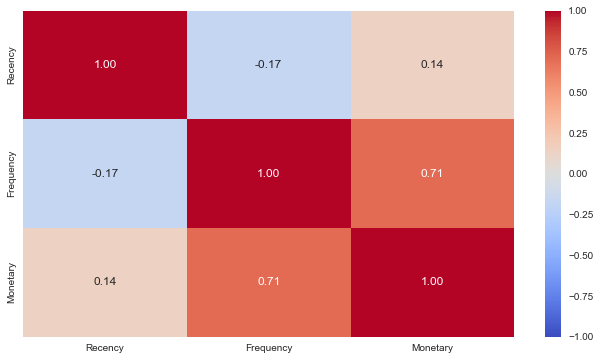

In [30]:
fig, ax = plt.subplots(figsize=(11, 6)) 
sns.heatmap (df_rfm1.corr(), 
             annot=True, 
             fmt= '.2f', 
             vmin=-1, 
             vmax=1, 
             center=0, 
             cmap='coolwarm',
             mask = np.zeros_like(df_rfm1.corr(), dtype = bool), 
             ax=ax);

RFM distribution

In [31]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('Recency','Frequency','Monetary'))

fig.add_trace(go.Histogram(x=df_rfm['Recency']),1,1)
fig.add_trace(go.Histogram(x=df_rfm['Frequency']),1,2)
fig.add_trace(go.Histogram(x=df_rfm['Monetary']),1,3)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,title_text="RFM value distribution")
fig.show()

Insight
- *Recency*

The range of Recency is from 0 to 1.062. The maximum value of recency is 1062, which indicates that a segment of consumers (about 23 customers from the Recency range 1040-1062) has not made a return or purchased in 1040-1062 days, which is a negative sign for business. 
- *Frequency*

 The Frequency values have small fluctuations from 1 to 3. There are 2241 customers that have a sum of order equal to 1, followed by 1318 customers that have a frequency of 2 and finally only 10 customers have total order equal to 3. That indicates that not many customers purchase a bunch of orders at once. Maybe the reason is due to the product category.
- *Monetary*

Likewise, in terms of the monetary, customers spent about from 539 to 6.640 in total. A consumer group with 636 travelers pays between $400 and $600. On the other hand, just roughly 10 consumers fall into the 6600–6800 expenditure category. That means, there are not many customers who spend a lot on this business.

In [32]:
df_rfm['R score'] = pd.qcut(df_rfm['Recency'], 5, labels=[5,4,3,2,1])
df_rfm['F score'] = pd.qcut(df_rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
df_rfm['M score'] = pd.qcut(df_rfm['Monetary'], 5, labels=[1,2,3,4,5])

df_rfm['RFM'] = df_rfm['R score'].astype(str) + df_rfm['F score'].astype(str) + df_rfm['M score'].astype(str)

df_rfm


Customer ID  Recency  Frequency  Monetary R score F score M score  RFM
0           11015      344          1   2319.99       1       1       3  113
1           11016      322          1   2294.99       1       1       3  113
2           11021      339          1   2294.99       1       1       3  113
3           11022      342          1   2319.99       1       1       3  113
4           11036      340          1   2319.99       1       1       3  113
...           ...      ...        ...       ...     ...     ...     ...  ...
3564        29334      867          1   3578.27       1       4       4  144
3565        29335      866          1   3578.27       1       4       4  144
3566        29350      866          1   3578.27       1       4       4  144
3567        29352      873          1   3578.27       1       4       4  144
3568        29354      858          1   3578.27       1       4       4  144

[3569 rows x 8 columns]

create segment base on RFM score ranking

In [33]:
rfm_segment = pd.read_excel('RFM_Customer_Segment.xlsx')
rfm_plot = rfm_segment.groupby('Customer Segment').agg(Customers=('CustomerKey', 'count')).sort_values(by='Customers', ascending=False).reset_index()
rfm_plot

Customer Segment  Customers
0              At Risk        677
1       About to Sleep        426
2            Promising        416
3   Potential Loyalist        415
4             Champion        402
5       Loyal Customer        330
6         New Customer        297
7          Hibernating        248
8     Cannot Lose Them        183
9                 Lost        154
10      Need Attention         21

In [34]:
rfm_segment.head(15).style.background_gradient(cmap='YlGn')

Treemap of customers segmentation

(0.0, 145.0, 0.0, 90.0)

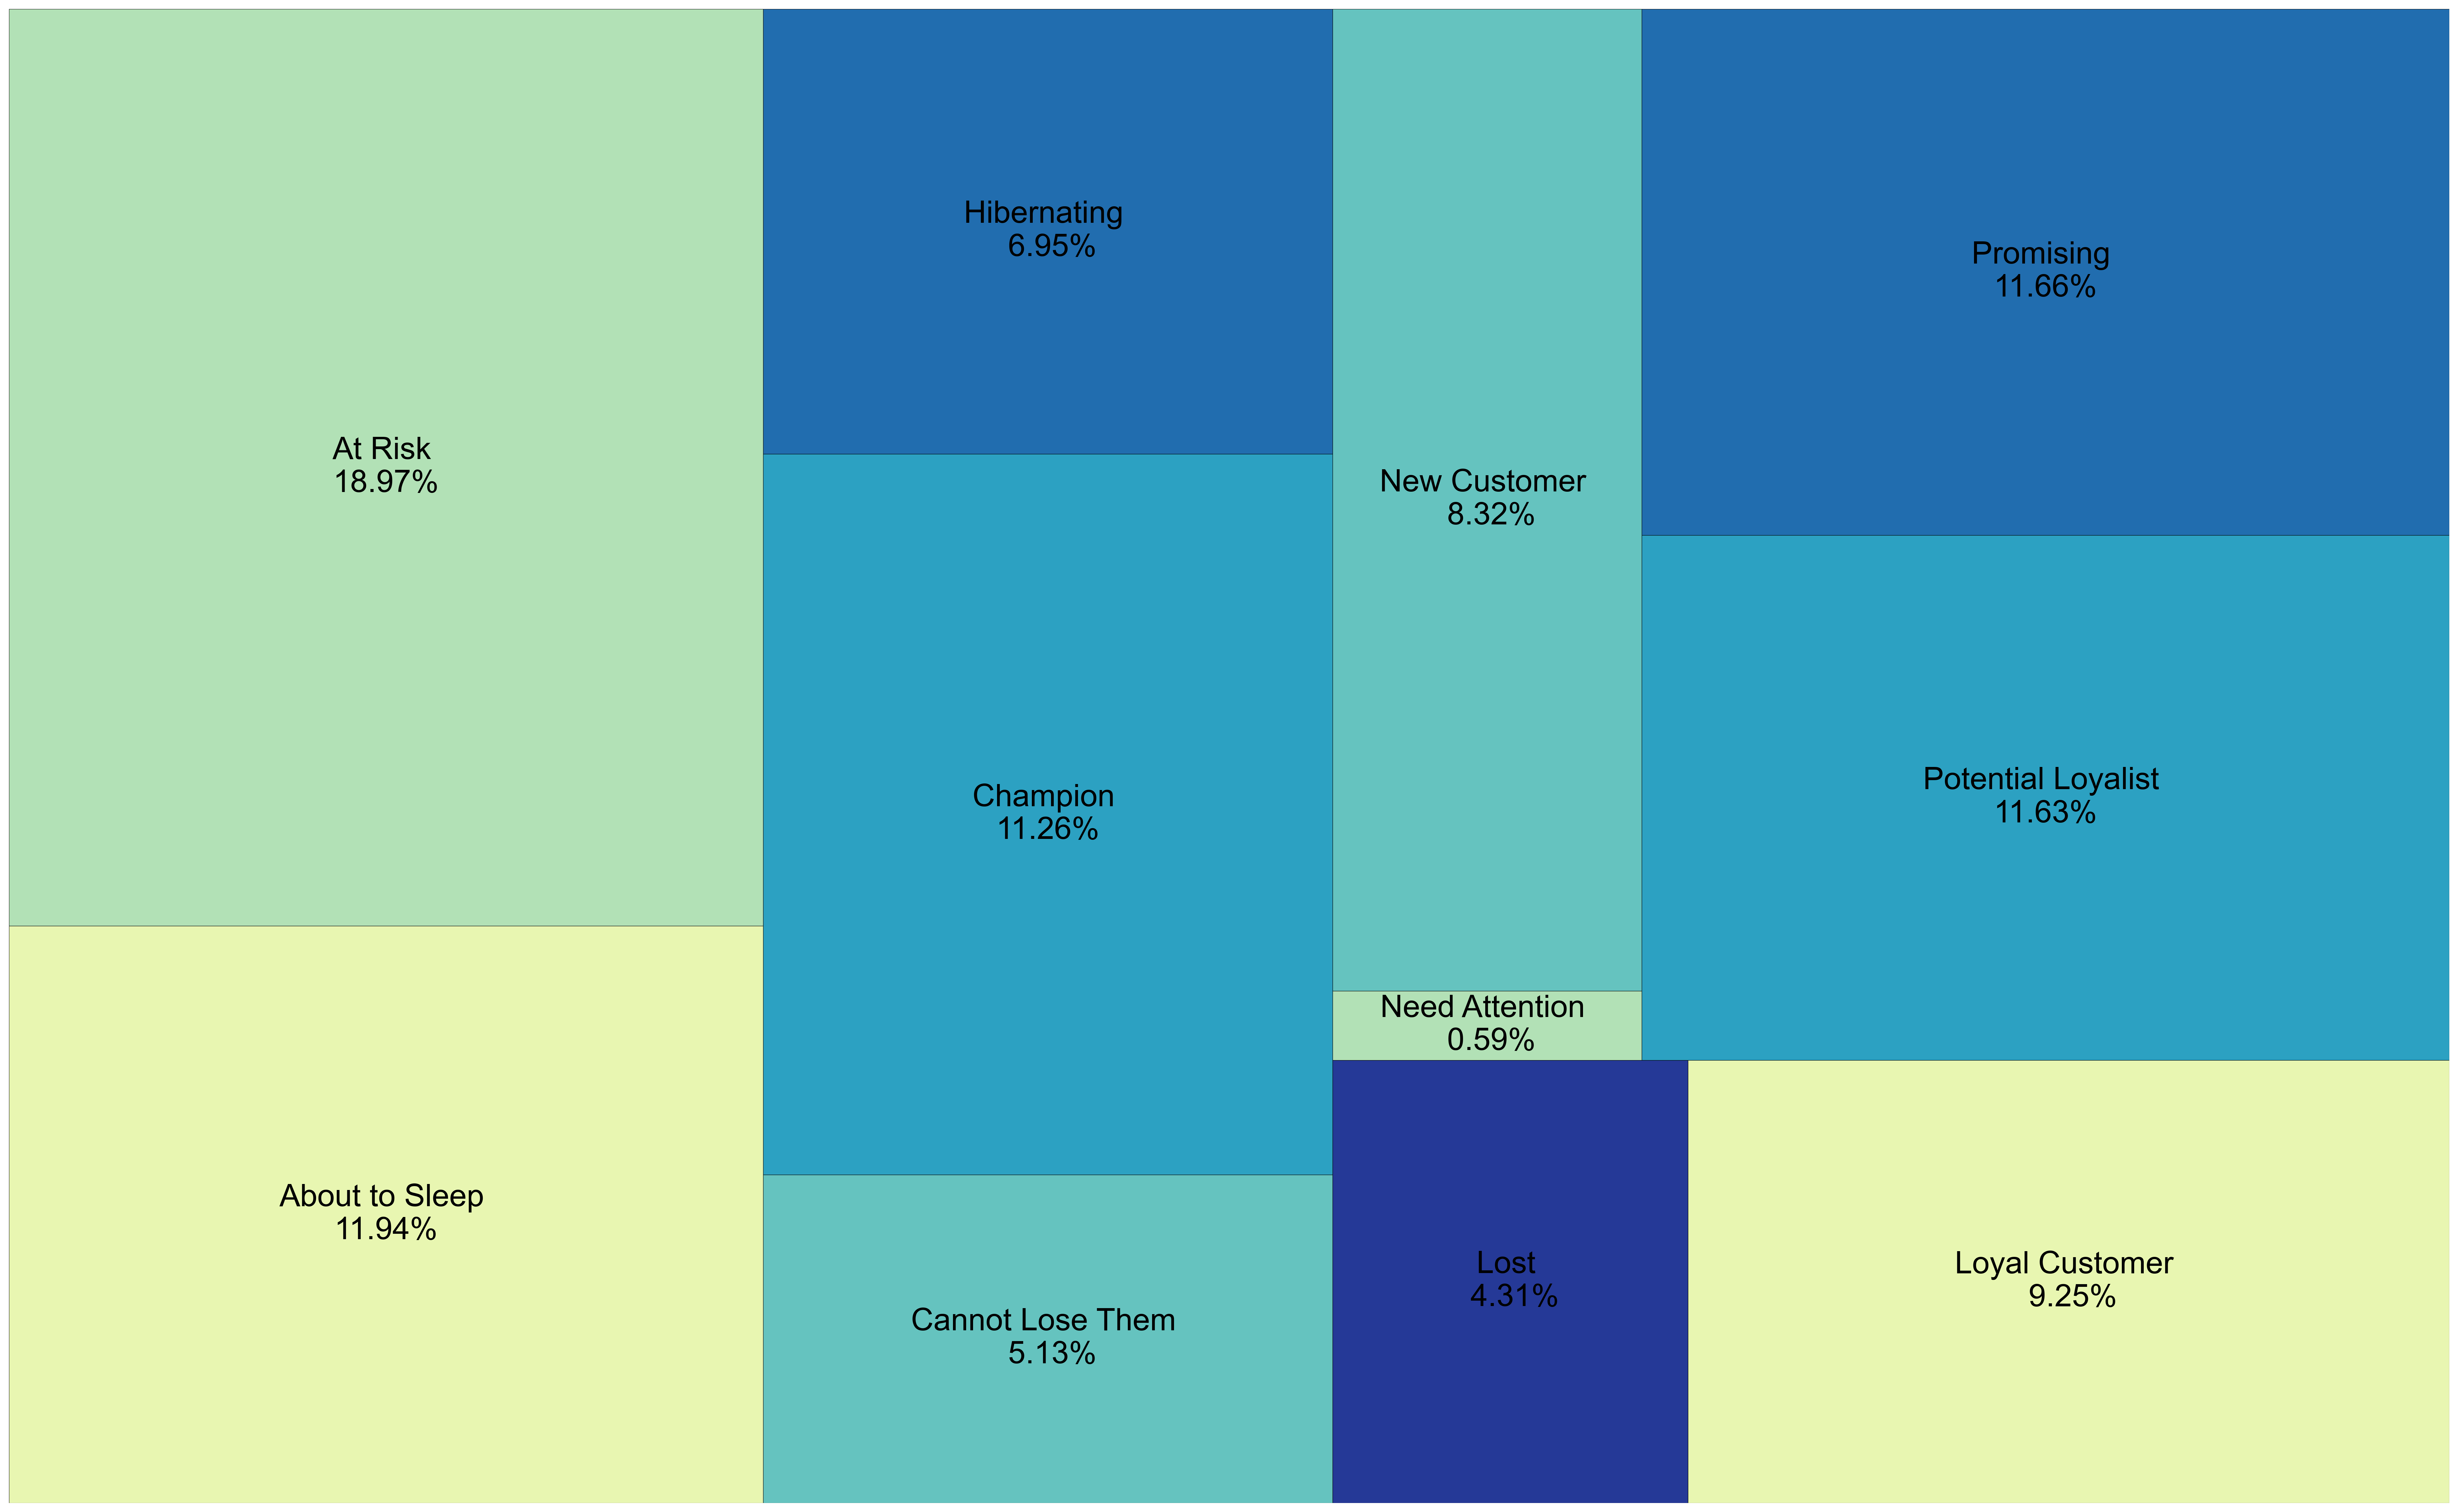

In [35]:
treemap = rfm_segment.groupby('Customer Segment').agg(Customers=('CustomerKey', 'count')).reset_index()
figure(figsize=(35, 22), dpi=300)
perc = [f'{i/treemap["Customers"].sum()*100:5.2f}%' for i in treemap['Customers']]
labels = [f'{el[0]} \n{el[1]}' for el in zip(treemap['Customer Segment'], perc)]
ax = squarify.plot(sizes=treemap['Customers'], label=labels, alpha=1, text_kwargs={'color': 'black', 'size': 25},
              color=sns.color_palette("YlGnBu"), 
              ec='black', norm_x=145, norm_y=90)
ax.axis('off')

Number of Customer per Segmentation

In [36]:
fig3 = make_subplots(rows=1, cols=1, shared_xaxes=True,
                    shared_yaxes=False, horizontal_spacing=0.002)
fig3.append_trace(go.Bar(
    x=rfm_plot['Customers'],
    y=rfm_plot['Customer Segment'],
    marker=dict(color='#078B86',
                line=dict(
                color='#078B86',
                width=1)), 
                orientation='h'),1,1)

fig3.update_layout(title='Number of Customers per segmentation',
                font_color= '#055956',
                title_font_color='#055956', 
                font_size=18,
                paper_bgcolor='#EFFFFE',
                plot_bgcolor='#EFFFFE',
                width=1200, height=500
                )
fig3.update_xaxes(title='Number of Customers')
fig3.update_yaxes(title='Customer Segment')
fig3.show()

In [37]:
round(rfm_segment['Customer Segment'].value_counts(normalize=True)*100,0)

At Risk               19.0
About to Sleep        12.0
Promising             12.0
Potential Loyalist    12.0
Champion              11.0
Loyal Customer         9.0
New Customer           8.0
Hibernating            7.0
Cannot Lose Them       5.0
Lost                   4.0
Need Attention         1.0
Name: Customer Segment, dtype: float64

Number of Customer per RFM values by Segmentation

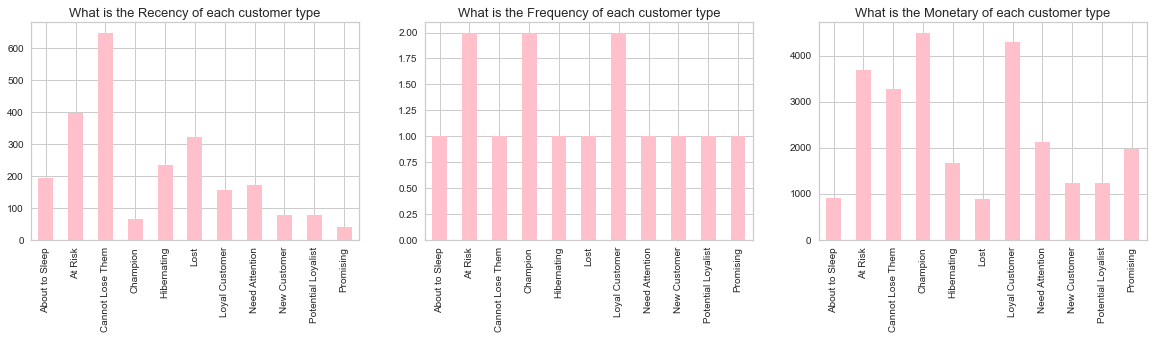

In [38]:
column = ['Recency','Frequency','Monetary']
plt.figure(figsize=(20,4))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    rfm_segment.groupby('Customer Segment')[j].mean().round(0).plot(kind='bar', color='pink')
    plt.title('What is the {} of each customer type'.format(j), size=13)
    plt.xlabel('')
    plt.xticks(rotation=90)

plt.show()

In [39]:
fig = px.scatter_matrix(rfm_segment[['Recency', 'Frequency', 'Monetary','Customer Segment']], 
                        dimensions=['Recency', 'Frequency', 'Monetary'], 
                        color=rfm_segment['Customer Segment'],
                        width=1000, height=800)

fig.show()

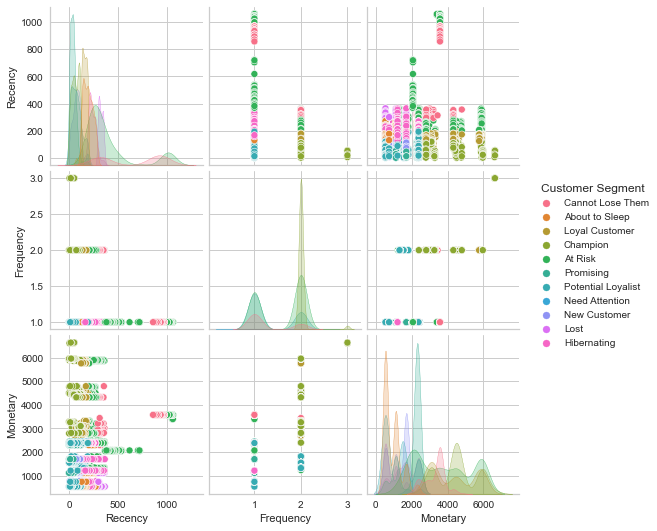

In [40]:
sns.pairplot(rfm_segment[['Recency', 'Frequency', 'Monetary','Customer Segment']], hue='Customer Segment');

In [41]:
fig = px.scatter_3d(rfm_segment, x='Recency', y='Frequency', z='Monetary',
              color='Customer Segment',opacity=0.7, height = 700,width = 900)
fig.show()

## Data Preprocessing

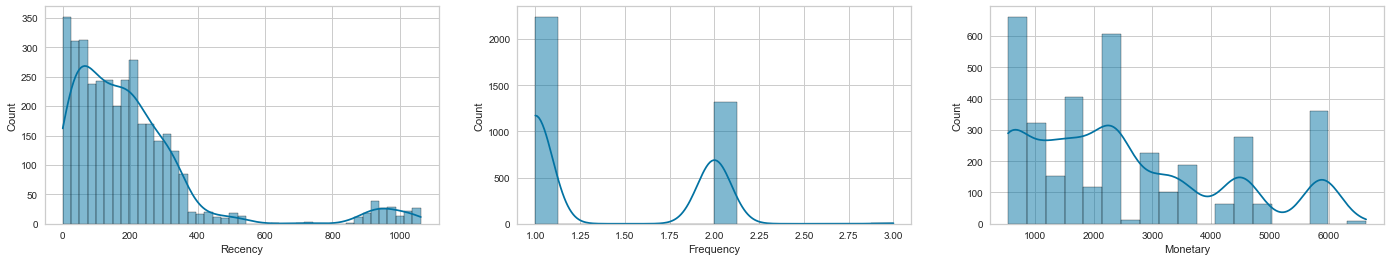

In [42]:
fig, ax = plt.subplots(1, 3, figsize = (24,4))   #tạo một dòng 3 cột
sns.histplot(x=df_rfm['Recency'], ax = ax[0],kde=True)      #vẽ cột đầu tiên
sns.histplot(df_rfm['Frequency'], ax = ax[1],kde=True)
sns.histplot(df_rfm['Monetary'], ax = ax[2],kde=True)

plt.show()

Recency, Frequency and Monetary values have a positive skew -> need to remove outliers and transform data to get efficient segmentation. 

Skewness risk is the increased risk of turning up a data point of high skewness in a skewed distribution. The more skewed the data, the less accurate this RFM model will be.


In [43]:
rfm_table = df_rfm.drop(columns=['R score','F score','M score','RFM','Customer ID'])
rfm_table.describe()

Recency    Frequency     Monetary
count  3569.000000  3569.000000  3569.000000
mean    204.569627     1.374895  2521.675408
std     212.433617     0.489918  1665.622903
min       0.000000     1.000000   539.990000
25%      67.000000     1.000000  1120.490000
50%     159.000000     1.000000  2294.990000
75%     260.000000     2.000000  3578.270000
max    1062.000000     3.000000  6640.610000

#### outlier value analysis
* outlier treatment: the algorithm we are going to use is vulnerable to outliers which are very very manipulative
* if you do not exclude outliers, the results will be heavily influenced

before outliers treatment

Text(0.5, 0, 'Attributes')

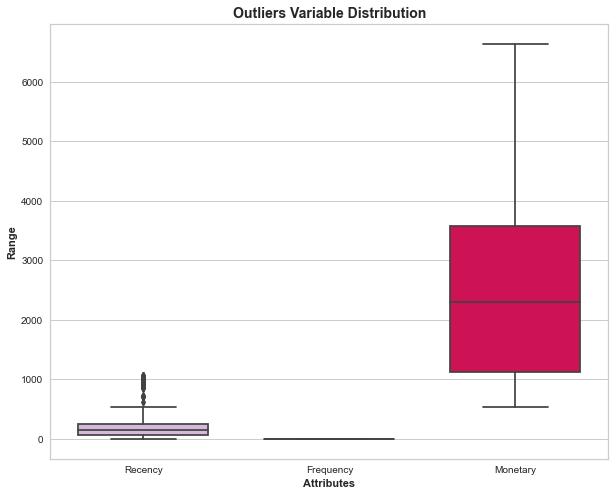

In [44]:
attributes = ['Recency','Frequency','Monetary']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm_table[attributes], orient="v", palette="PuRd" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [45]:
def show_outliers(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - 1.5*iqr
    fence_high = q3 + 1.5*iqr
    outliers_df = df.loc[(df[col] < fence_low) | (df[col] > fence_high)]
    return print('Numbers of outliers in {}'.format(col),len(outliers_df))

In [46]:
for i in ["Recency", "Frequency", "Monetary"]:
    show_outliers(rfm_table, i)
    print("_"*40)

Numbers of outliers in Recency 195
________________________________________
Numbers of outliers in Frequency 0
________________________________________
Numbers of outliers in Monetary 0
________________________________________


In [47]:
for i in rfm_table[attributes]:
    # ---------------------Finding the IQR---------------------------
    q1 = rfm_table[i].quantile(0.25)
    q3 = rfm_table[i].quantile(0.75)
    # ----------------Finding upper and lower limit------------------
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    # # ------------------------Finding Outliers----------------------------
    rfm_table.loc[rfm_table[i] > upper_limit,i] = upper_limit
    rfm_table.loc[rfm_table[i] < lower_limit,i] = lower_limit
# # ---------------------------------Trimming------------------------------------
rfm_table = rfm_table[rfm_table[['Recency','Frequency', 'Monetary']] < upper_limit]
rfm_table = rfm_table.dropna(axis=0)
rfm_table

Recency  Frequency  Monetary
0       344.0        1.0   2319.99
1       322.0        1.0   2294.99
2       339.0        1.0   2294.99
3       342.0        1.0   2319.99
4       340.0        1.0   2319.99
...       ...        ...       ...
3564    549.5        1.0   3578.27
3565    549.5        1.0   3578.27
3566    549.5        1.0   3578.27
3567    549.5        1.0   3578.27
3568    549.5        1.0   3578.27

[3569 rows x 3 columns]

In [48]:
for i in ["Recency", "Frequency", "Monetary"]:
    show_outliers(rfm_table, i)
    print("_"*40)

Numbers of outliers in Recency 0
________________________________________
Numbers of outliers in Frequency 0
________________________________________
Numbers of outliers in Monetary 0
________________________________________


after outliers treatment

Text(0.5, 0, 'Attributes')

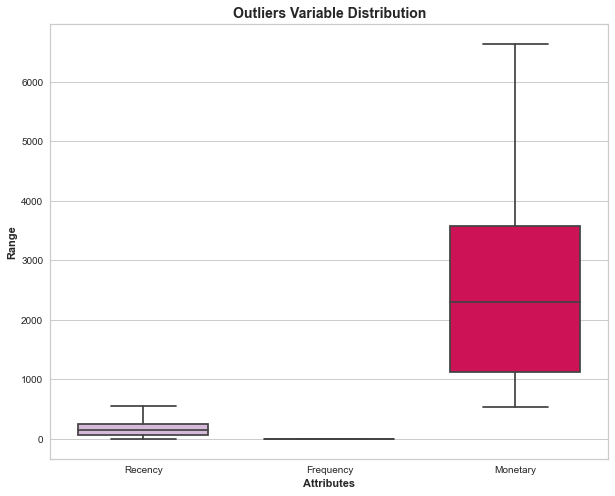

In [49]:
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm_table[attributes], orient="v", palette="PuRd" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

## Data Transformation

only take positive value because boxcox transformation data required positive data

In [50]:
rfm_normal = rfm_table.copy()
rfm_normal = rfm_normal[rfm_normal['Recency']>0]

In [51]:
# Transformation process to get the skewness close to 0
# Log transformation
rfm_log = rfm_normal.copy()
rfm_log = np.log(rfm_log[['Recency','Frequency','Monetary']])
# Square root transformation
rfm_sqrt = rfm_normal.copy()
rfm_sqrt = np.sqrt(rfm_sqrt[['Recency','Frequency','Monetary']])
# Cube root transformation
rfm_cbrt = rfm_normal.copy()
rfm_cbrt = np.cbrt(rfm_cbrt[['Recency','Frequency','Monetary']])
# Box cox transformation
rfm_boxcox = rfm_normal.copy()

#boxcox require 1-dimension data
rfm_boxcox['Recency'] = boxcox(rfm_boxcox['Recency'])[0]
rfm_boxcox['Frequency'] = boxcox(rfm_boxcox['Frequency'])[0]
rfm_boxcox['Monetary'] = boxcox(rfm_boxcox['Monetary'])[0]

## Skewness
* The skewness value greater than 1 or less than -1 indicates a highly skewed distribution.
* The value between 0.5 and 1 or -0.5 and -1 is moderately skewed.
* The value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.

In [52]:
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.histplot(np.cbrt(rfm_normal[x]), ax=ax[0,0]).set(title='Cbrt transform: {}'.format(np.cbrt(rfm_normal[x]).skew().round(2)))
    sns.histplot(np.log(rfm_normal[x]), ax=ax[0,1]).set(title='Log transform: {}'.format(np.log(rfm_normal[x]).skew().round(2)))
    sns.histplot(np.sqrt(rfm_normal[x]), ax=ax[1,0]).set(title='Sqrt transform: {}'.format(np.sqrt(rfm_normal[x]).skew().round(2)))
    sns.histplot(boxcox(rfm_normal[x])[0], ax=ax[1,1]).set(title='Boxcox transform: {}'.format(pd.Series(boxcox(rfm_normal[x])[0]).skew().round(2)))
    plt.tight_layout()
    plt.show()
    
    print("original skew: ",rfm_normal[x].skew().round(2))
    print("log transform: {}".format(np.log(rfm_normal[x]).skew().round(2)))
    print("sqrt transform: {}".format(np.sqrt(rfm_normal[x]).skew().round(2)))
    print("boxcox transform: {}".format(pd.Series(boxcox(rfm_normal[x])[0]).skew().round(2)))

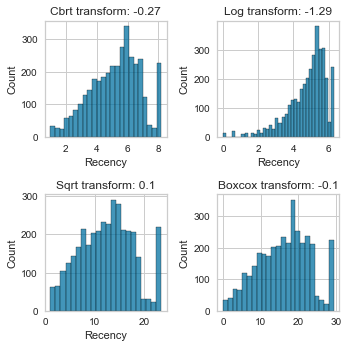

original skew:  0.99
log transform: -1.29
sqrt transform: 0.1
boxcox transform: -0.1


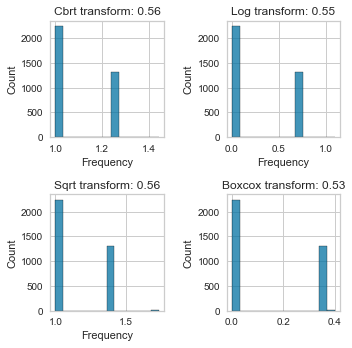

original skew:  0.59
log transform: 0.55
sqrt transform: 0.56
boxcox transform: 0.53


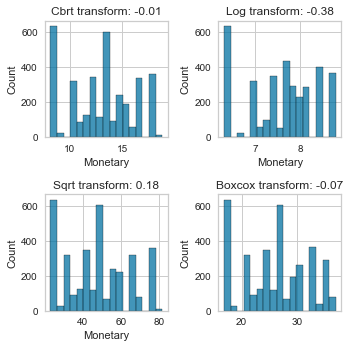

original skew:  0.69
log transform: -0.38
sqrt transform: 0.18
boxcox transform: -0.07


In [53]:
for col, i in zip(['Recency','Frequency','Monetary'], range (3)):
    analyze_skewness(col)

In [54]:
def check_skew(df):
    fig, ax = plt.subplots(1, 3, figsize = (24,4))
    for col, i in zip(['Recency','Frequency','Monetary'], range (3)):
        skewness = skew(df[col])
        sns.histplot(df[col],ax=ax[i],kde=True)
        print("{}'s skew: {}".format(col, skewness))
    plt.show()
    return

Recency's skew: -0.10279972619146552
Frequency's skew: 0.5299208443962065
Monetary's skew: -0.07213661978672894


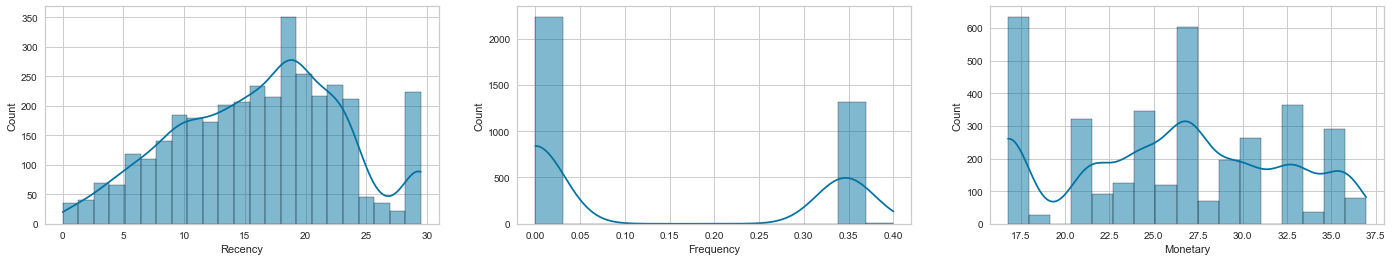

In [55]:
# Box cox transformation
check_skew(rfm_boxcox)

Recency's skew: 0.09728238516229436
Frequency's skew: 0.5609229973480802
Monetary's skew: 0.18002823621970274


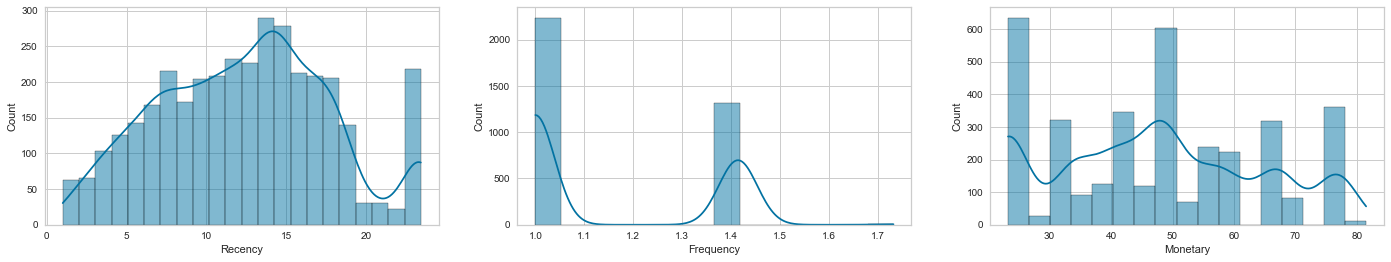

In [56]:
# Square root transformation
check_skew(rfm_sqrt)

Recency's skew: -1.2853742899000455
Frequency's skew: 0.5461864886057363
Monetary's skew: -0.3758515577495808


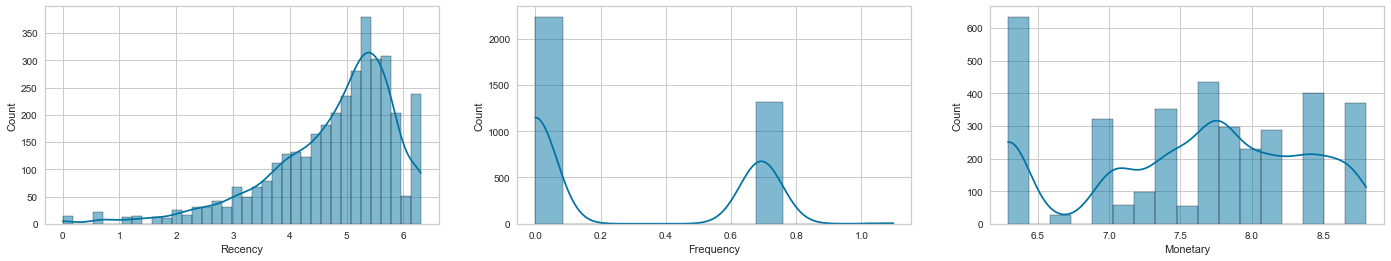

In [57]:
# Log transformation
check_skew(rfm_log)

Recency's skew: -0.2711998952268569
Frequency's skew: 0.5549799090711118
Monetary's skew: -0.00515610048011136


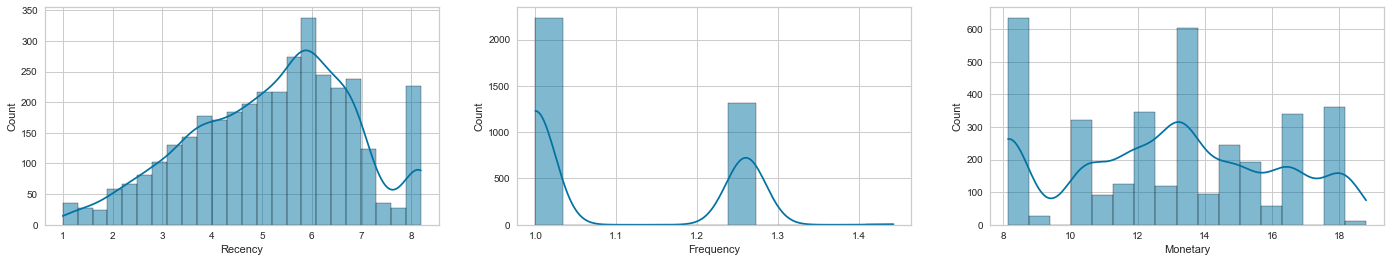

In [58]:
# Cube root transformation
check_skew(rfm_cbrt)

## Data Normalization

#### scaling the RFM data

In [59]:
standard_scaler = StandardScaler()
rfm_scaled = rfm_boxcox[['Recency', 'Frequency', 'Monetary']].values
rfm_scaled = standard_scaler.fit_transform(rfm_boxcox)
rfm_scaled = pd.DataFrame(rfm_scaled)
rfm_scaled.columns = ['Recency','Frequency','Monetary']

rfm_scaled.head(10).style.background_gradient('YlGn')

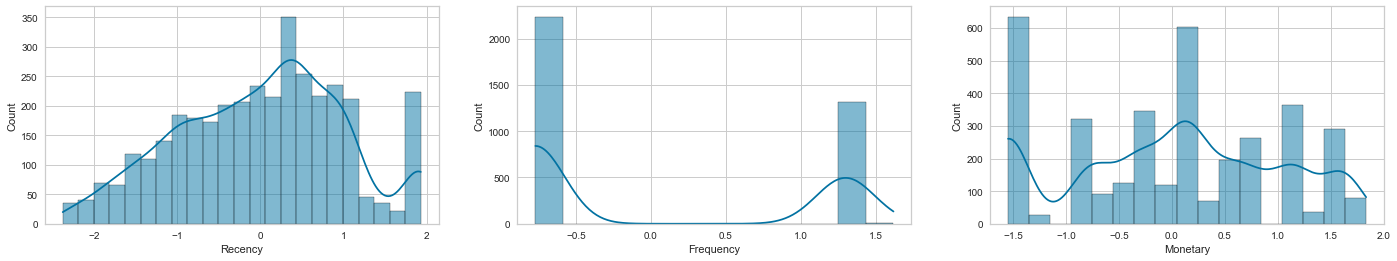

In [60]:
fig, ax = plt.subplots(1,3,figsize=(24,4))
sns.histplot(x=rfm_scaled['Recency'], ax = ax[0],kde=True)      
sns.histplot(x=rfm_scaled['Frequency'], ax = ax[1],kde=True)
sns.histplot(x=rfm_scaled['Monetary'], ax = ax[2],kde=True)

plt.show()

Correlation between Scaled RFM values in dataset

<AxesSubplot:>

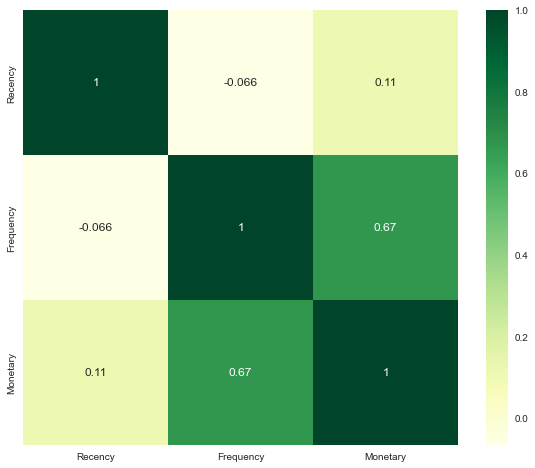

In [61]:
fig, axis = plt.subplots(figsize=(10, 8))
corr = rfm_scaled.corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = bool), cmap = 'YlGn',
            square = True, ax = axis, annot=True)

## K-Means

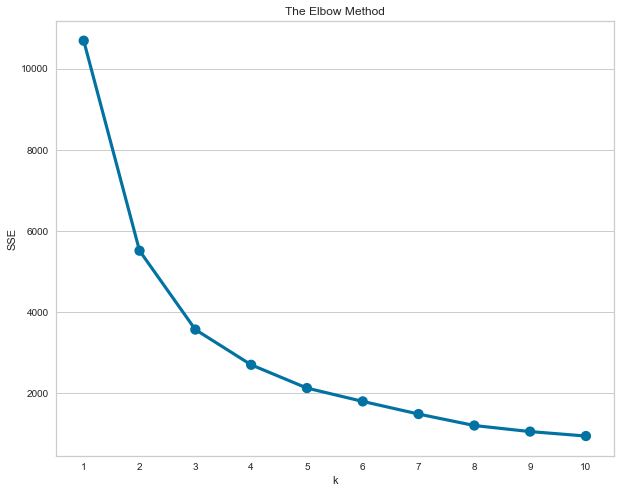

In [62]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_ 
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Elbow method results is 3

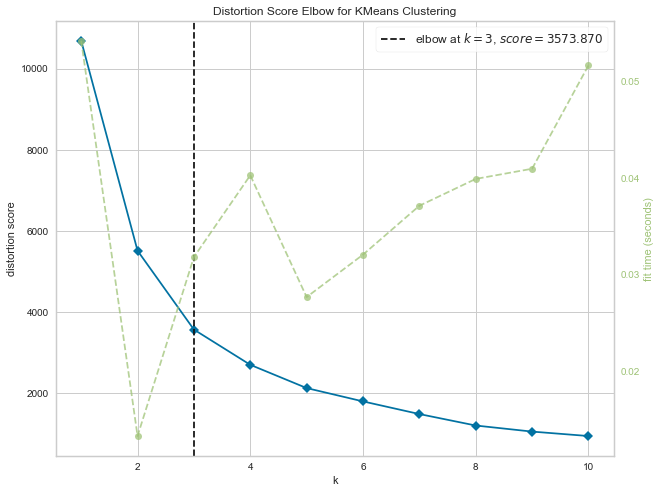

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:
elbow = KElbowVisualizer(kmeans, k=(1,11))
elbow.fit(rfm_scaled)
elbow.show()

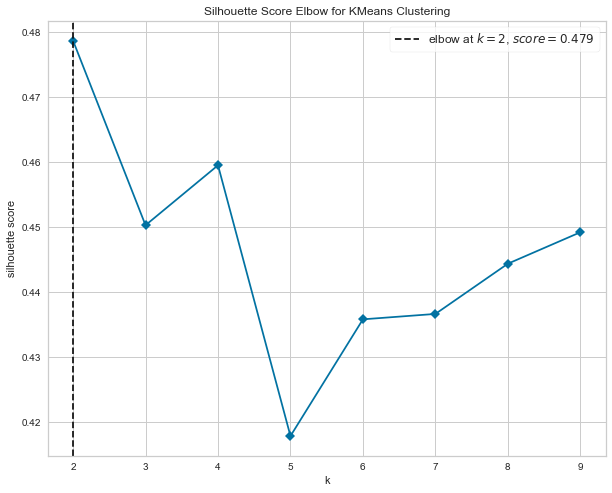

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [64]:
Elbow_M = KElbowVisualizer(KMeans(), k=(2,10),metric='silhouette', timings=False)
Elbow_M.fit(rfm_scaled)
Elbow_M.show()

## silhouette_score

In [65]:
#Silhouette Score
range_n_clusters = [2,3,4,5,6,7,8,9,10]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters,random_state=1)
    preds = clusterer.fit_predict(rfm_scaled)
    centers = clusterer.cluster_centers_

    score = silhouette_score(rfm_scaled, preds)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.4786706439840829
For n_clusters = 3, silhouette score is 0.4503468055361069
For n_clusters = 4, silhouette score is 0.4595192108703561
For n_clusters = 5, silhouette score is 0.41799055661535617
For n_clusters = 6, silhouette score is 0.4358373185593651
For n_clusters = 7, silhouette score is 0.4357638274835816
For n_clusters = 8, silhouette score is 0.44184085567024833
For n_clusters = 9, silhouette score is 0.45275456065261194
For n_clusters = 10, silhouette score is 0.4404658111175349


In [66]:
model = KMeans(n_clusters=3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
model.fit(rfm_scaled.values)

KMeans(n_clusters=3, random_state=0)

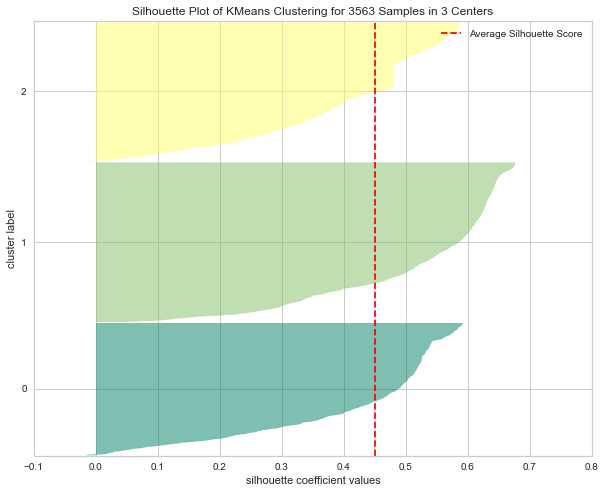

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3563 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [67]:
visualizer = SilhouetteVisualizer(model, colors='summer')

visualizer.fit(rfm_scaled.values)        # Fit the data to the visualizer
visualizer.show()  

The centroids of the K clusters, which can be used to label new data

Labels for the training data (each data point is assigned to a single cluster)

In [68]:
rfm_scaled['Cluster'] = model.labels_
rfm_scaled.head()

Recency  Frequency  Monetary  Cluster
0  1.122264  -0.769798  0.131878        2
1  1.020114  -0.769798  0.116775        2
2  1.099396  -0.769798  0.116775        2
3  1.113141  -0.769798  0.131878        2
4  1.103986  -0.769798  0.131878        2

In [69]:
rfm_scaled.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'Monetary':'mean'
    }
).round(2).T

Cluster       0     1     2
Recency   -0.90 -0.07  0.94
Frequency -0.76  1.30 -0.77
Monetary  -0.67  0.88 -0.37

In [70]:
rfm_scaled['Cluster'].value_counts()

1    1320
2    1149
0    1094
Name: Cluster, dtype: int64

Distribution Of The Clusters

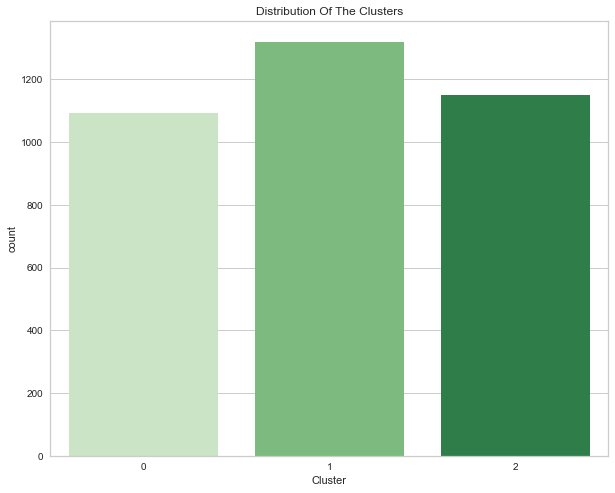

In [71]:
pl = sns.countplot(x=rfm_scaled['Cluster'], palette= 'Greens')
pl.set_title("Distribution Of The Clusters")
plt.show()

In [72]:
fig = px.pie(rfm_scaled, values = rfm_scaled['Cluster'].value_counts(), 
                names = (rfm_scaled['Cluster'].value_counts()).index, 
                title = 'Predicted Clusters Distribution',
                width=500, height=500,
                color_discrete_sequence=px.colors.sequential.Blugrn)
fig.show()

In [73]:
rfm_normal['Cluster'] = model.labels_
rfm_normal.head()

Recency  Frequency  Monetary  Cluster
0    344.0        1.0   2319.99        2
1    322.0        1.0   2294.99        2
2    339.0        1.0   2294.99        2
3    342.0        1.0   2319.99        2
4    340.0        1.0   2319.99        2

<Figure size 1440x1440 with 0 Axes>

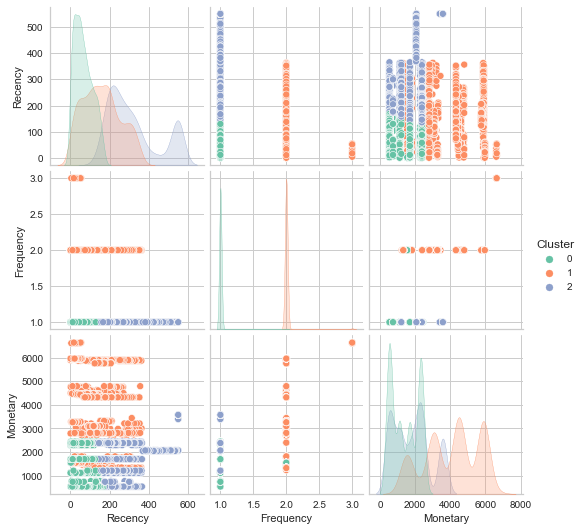

In [74]:

plt.figure(figsize=(20, 20))
sns.pairplot(rfm_normal, hue='Cluster' , diag_kind=  'kde',
             palette=sns.color_palette('Set2', n_colors=3))

<AxesSubplot:xlabel='Frequency', ylabel='Monetary'>

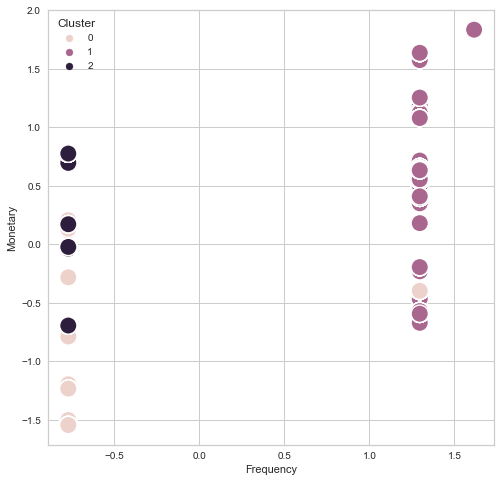

In [75]:
plt.figure(figsize=(8,8))
sns.scatterplot(data = rfm_scaled, x='Frequency', y='Monetary', hue='Cluster', s=300)

In [76]:
X = rfm_scaled[['Recency' , 'Frequency' ,'Monetary']].iloc[: , :].values

labels = model.labels_
centroids = model.cluster_centers_

In [77]:
trace = go.Scatter3d(
    x= rfm_scaled['Recency'],
    y= rfm_scaled['Frequency'],
    z= rfm_scaled['Monetary'],
    mode='markers',
    marker=dict(
        color = labels, 
        colorscale = 'peach',
        size= 20,
        # line=dict(
        #     color= labels,
        #     colorscale = 'peach',
        #     width= 12
        # ),
        opacity=0.8
     )
)
data = [trace]
layout = go.Layout(
    margin=dict(l=0,r=0),
    height = 700,width = 700,
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Recency'),
            yaxis = dict(title  = 'Frequency'),
            zaxis = dict(title  = 'Monetary')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

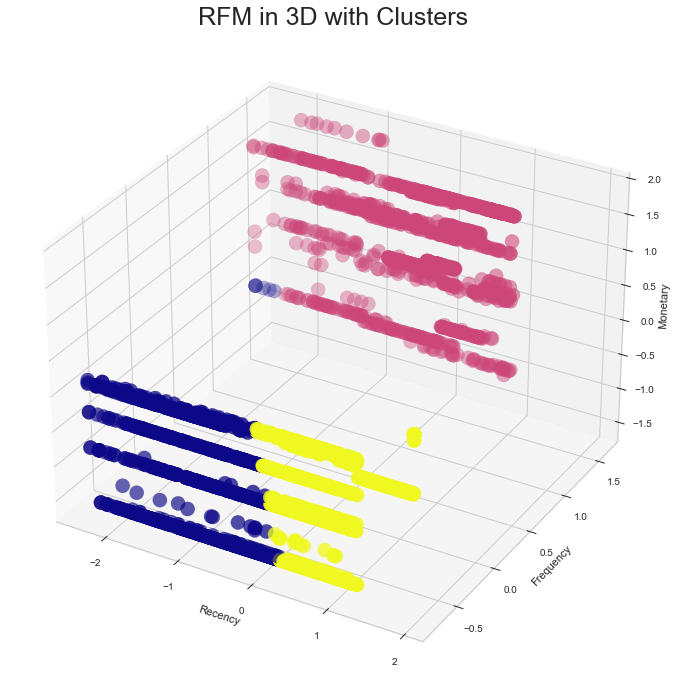

In [78]:
# Creating figure
fig = plt.figure(figsize = (12, 12))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(rfm_scaled.Recency, rfm_scaled.Frequency, rfm_scaled.Monetary, c=rfm_scaled.Cluster, cmap='plasma',s=200)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('RFM in 3D with Clusters', size=25)
ax.set(facecolor='white')
plt.show()

### Relative importance

Heat Map
We will utilize heat map to visualize the relative importance of each attributes in all four customer segments i.e. clusters. It calculates importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average).

The farther a ratio is from 0, the more important that attribute is for a segment relative to the total population.

In [79]:
# Average attributes for each cluster
cluster_avg = rfm_normal.groupby(['Cluster']).mean() 

# Calculate the population average
population_avg = cluster_avg.mean()

# Calculate relative importance of attributes by 
relative_imp = cluster_avg / population_avg - 1
print(relative_imp.round(2))

         Recency  Frequency  Monetary
Cluster                              
0          -0.64      -0.25     -0.42
1          -0.13       0.50      0.67
2           0.76      -0.25     -0.25


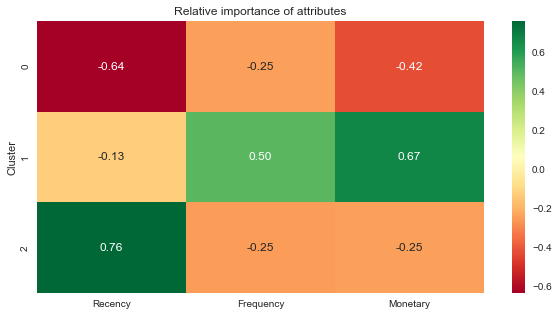

In [80]:
plt.figure(figsize=(10, 5))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

In [81]:
# Function to visualize clusters
def rfm_clusters_stat(df):
    df_new = df.groupby(['Cluster']).agg({
            'Recency'  : ['mean','median', 'min', 'max'],
            'Frequency': ['mean','median', 'min', 'max'],
            'Monetary' : ['mean','median', 'min', 'max', 'count']
        }).round(6)

    return df_new

In [82]:

rfm_clusters_stat(rfm_scaled).style.background_gradient(cmap='YlGn_r')

In [83]:
RFM_stats= pd.DataFrame(rfm_clusters_stat(rfm_scaled))

Text(0.5, 0.98, 'Segments of Customers')

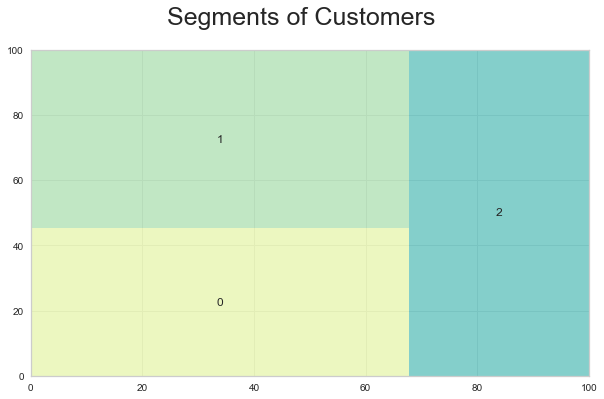

In [84]:

# Visualize Segments
plt.figure(figsize=(10, 6))
squarify.plot(sizes=RFM_stats["Monetary"]["count"], label=RFM_stats.index, color=sns.color_palette("YlGnBu"), alpha=0.8)
plt.suptitle("Segments of Customers", fontsize=25)

| Cluster| Recency | Frequency | Monetary | Value |
| ----------- | ----------- | ----------- | ----------- |----------- |
| 0   | Low |Low |Low |Low value customers |
| 0   | Low |High|High |High value customers |
| 0   | High |Low |Low |Mid value customers |


## Customer Lifetime Value

In [85]:
df_cohort = aw_df.drop(columns=['Order Quantity' ,'OrderDateKey', 'Product', 'Model', 'Subcategory',
       'Category',  'Customer', 'City', 'State-Province','Country-Region'])
df_cohort.head()

SalesOrderLineKey  CustomerKey  ProductKey  Sales Amount       Date
0           43711001        27606         314       3578.27 2017-07-02
1           71134001        27606         563       2384.07 2020-04-21
2           43706001        27621         312       3578.27 2017-07-02
3           71203001        27621         561       2384.07 2020-04-22
4           43707001        27616         312       3578.27 2017-07-02

In [86]:
# Define a function that will parse the date
def get_month(x):
    return dt.datetime(x.year,x.month,1) 

In [87]:
# Create InvoiceMonth column
df_cohort['InvoiceMonth'] = df_cohort['Date'].apply(get_month)

# getting the first time purchase date for each customer
df_cohort['CohortMonth'] = df_cohort.groupby('CustomerKey')['InvoiceMonth'].transform('min')

# converting the variable to datetime format
df_cohort['InvoiceMonth'] = pd.to_datetime(df_cohort['InvoiceMonth'])

In [88]:
def diff_month(d1, d2):
    return((d1.dt.year - d2.dt.year) * 12 + d1.dt.month - d2.dt.month)

In [89]:
df_cohort['CohortPeriod'] = diff_month(df_cohort['InvoiceMonth'], df_cohort['CohortMonth'])

In [90]:
customer_cohort = df_cohort.pivot_table(index='CohortMonth', columns='CohortPeriod', values='CustomerKey', aggfunc='nunique')
customer_cohort.style.background_gradient(cmap='GnBu')

In [91]:
cohort_size = customer_cohort.iloc[:,0]
retention = customer_cohort.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis
retention.index = pd.to_datetime(retention.index).date
retention.round(3) * 100 #to show the number as percentage

CohortPeriod     0    3    4     5    6     7     8     9     10    11  ...  \
2017-07-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2017-08-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2017-09-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2017-10-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2017-11-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2017-12-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2018-01-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2018-02-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2018-03-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2018-04-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2018-05-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2018-06-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2018-07-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   1.0  ...   
2018-08-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN  11.3   7.5  ...   
2018-09-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   4.4  ...   
2018-10-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2018-11-01    100.0  NaN  NaN   NaN  NaN   1.2   NaN   NaN   NaN   3.7  ...   
2018-12-01    100.0  NaN  NaN   NaN  9.8   6.6   NaN   NaN   4.9   6.6  ...   
2019-01-01    100.0  NaN  NaN   6.0  9.0   1.5   NaN   7.5  13.4   NaN  ...   
2019-02-01    100.0  NaN  6.5  10.9  4.3   NaN   NaN  26.1   NaN   2.2  ...   
2019-03-01    100.0  NaN  NaN   6.6  2.6   NaN  25.0   6.6   NaN  22.4  ...   
2019-04-01    100.0  NaN  6.7   2.2  2.2   5.6  20.2   2.2   9.0  23.6  ...   
2019-05-01    100.0  2.2  NaN   NaN  9.0  16.9   4.5  19.1   6.7  12.4  ...   
2019-06-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   1.0   6.9   1.0  ...   
2019-07-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2019-08-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2019-09-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2019-10-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2019-11-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2019-12-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2020-01-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2020-02-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2020-03-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2020-04-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
2020-05-01    100.0  NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   

CohortPeriod    25    26    27    28   29   30   31    32    33   34  
2017-07-01     NaN   NaN   NaN   8.8  8.8  3.8  NaN   1.2  37.5  6.2  
2017-08-01     NaN   NaN   1.9  11.1  9.3  NaN  NaN   3.7  22.2  NaN  
2017-09-01     NaN   7.1  14.3   1.8  1.8  NaN  NaN  33.9   NaN  NaN  
2017-10-01     1.6  12.9   NaN   8.1  1.6  1.6  1.6   NaN   NaN  NaN  
2017-11-01     9.0   9.0   4.5   2.2  NaN  NaN  NaN   NaN   NaN  NaN  
2017-12-01    17.9   9.0  14.9   NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2018-01-01     4.8  14.3   9.5  16.7  NaN  NaN  NaN   NaN   NaN  NaN  
2018-02-01     1.5   9.2   3.1   NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2018-03-01     3.5   NaN   NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2018-04-01     1.2   NaN   NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2018-05-01     NaN   NaN   NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2018-06-01     NaN   NaN   NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2018-07-01     NaN   NaN   NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2018-08-01     NaN   NaN   NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2018-09-01     NaN   NaN   NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2018-10-01     NaN 

#### Number of New Customers in Cohorts

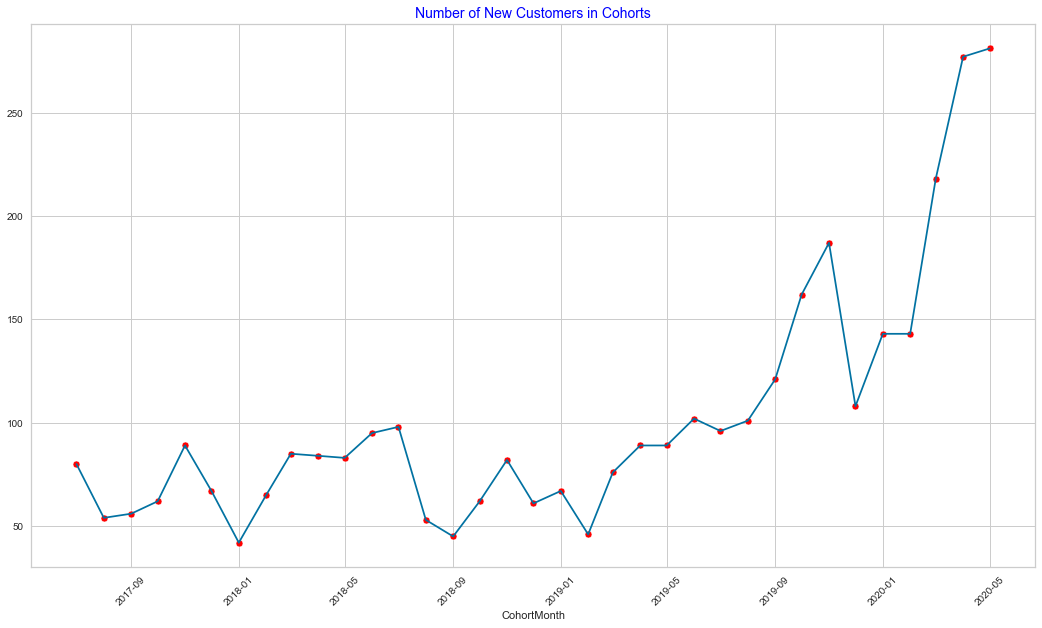

In [92]:
plt.figure(figsize=(18,10))
plt.title("Number of New Customers in Cohorts", c="blue", size=14)
sns.lineplot(x=customer_cohort.iloc[:,0].index, y=customer_cohort.iloc[:,0].values)
sns.scatterplot(x=customer_cohort.iloc[:,0].index, y=customer_cohort.iloc[:,0].values, sizes=50, color="red")
plt.xticks(rotation=45);

In [93]:
amount_cohort = df_cohort.pivot_table(index='CohortMonth', columns='CohortPeriod', values='Sales Amount', aggfunc='mean').round(1)
amount_cohort.index = pd.to_datetime(amount_cohort.index).date

#### Retention by Monthly Cohorts

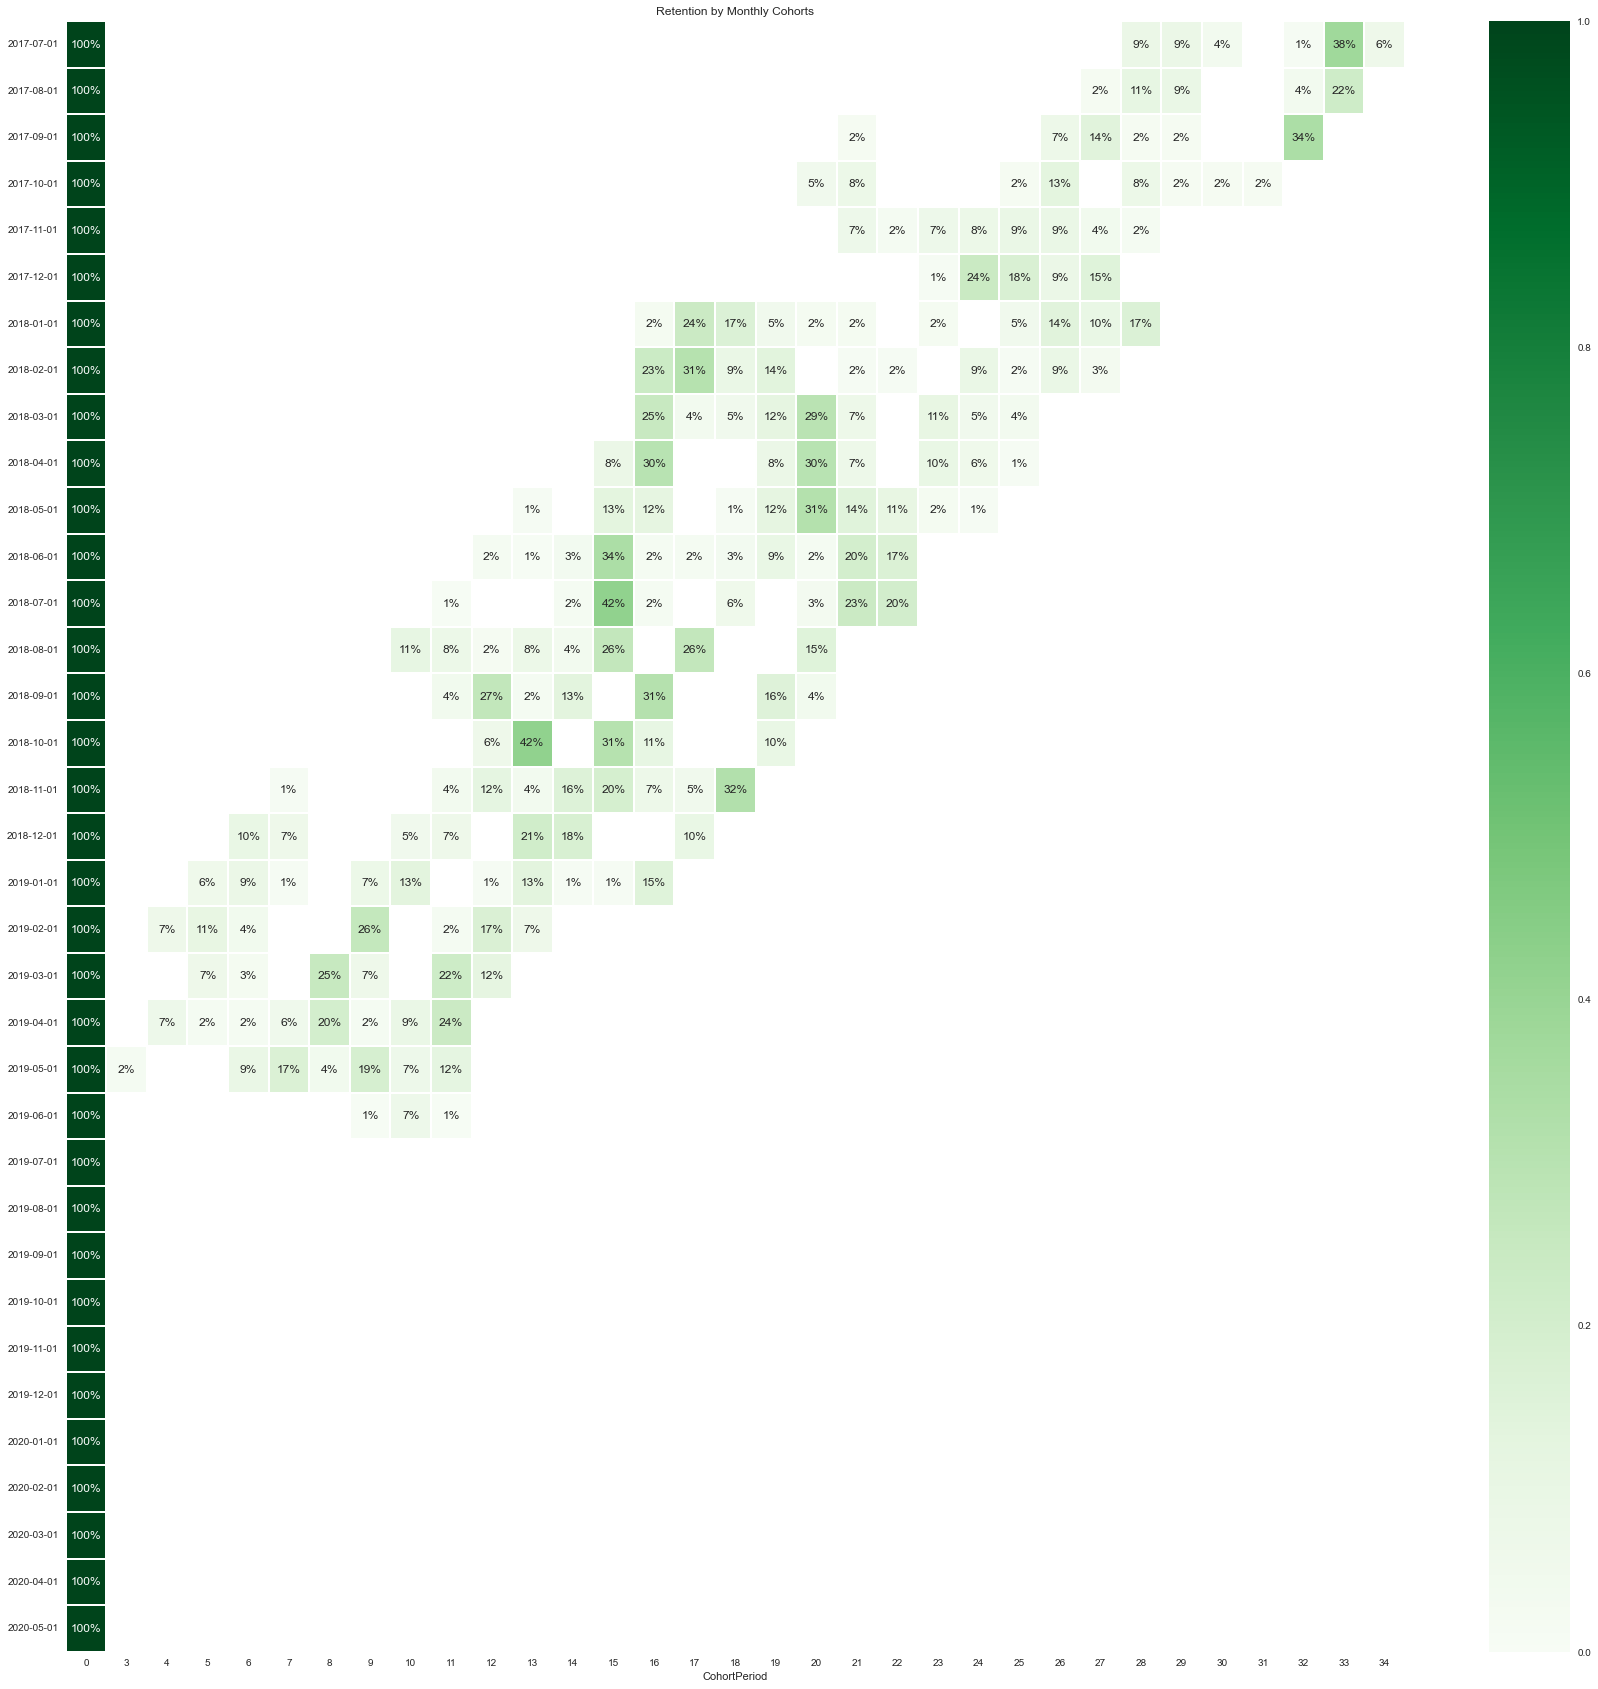

In [94]:
# Initialize inches plot figure
plt.figure(figsize=(30,30))

# Add a title
plt.title('Retention by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data=retention,
            annot = True,
            cmap = "Greens",
            vmin = 0.0,
            fmt = '.0%',
            linewidth = 0.3,)
plt.show()

#### Average sales amount by Monthly Cohorts

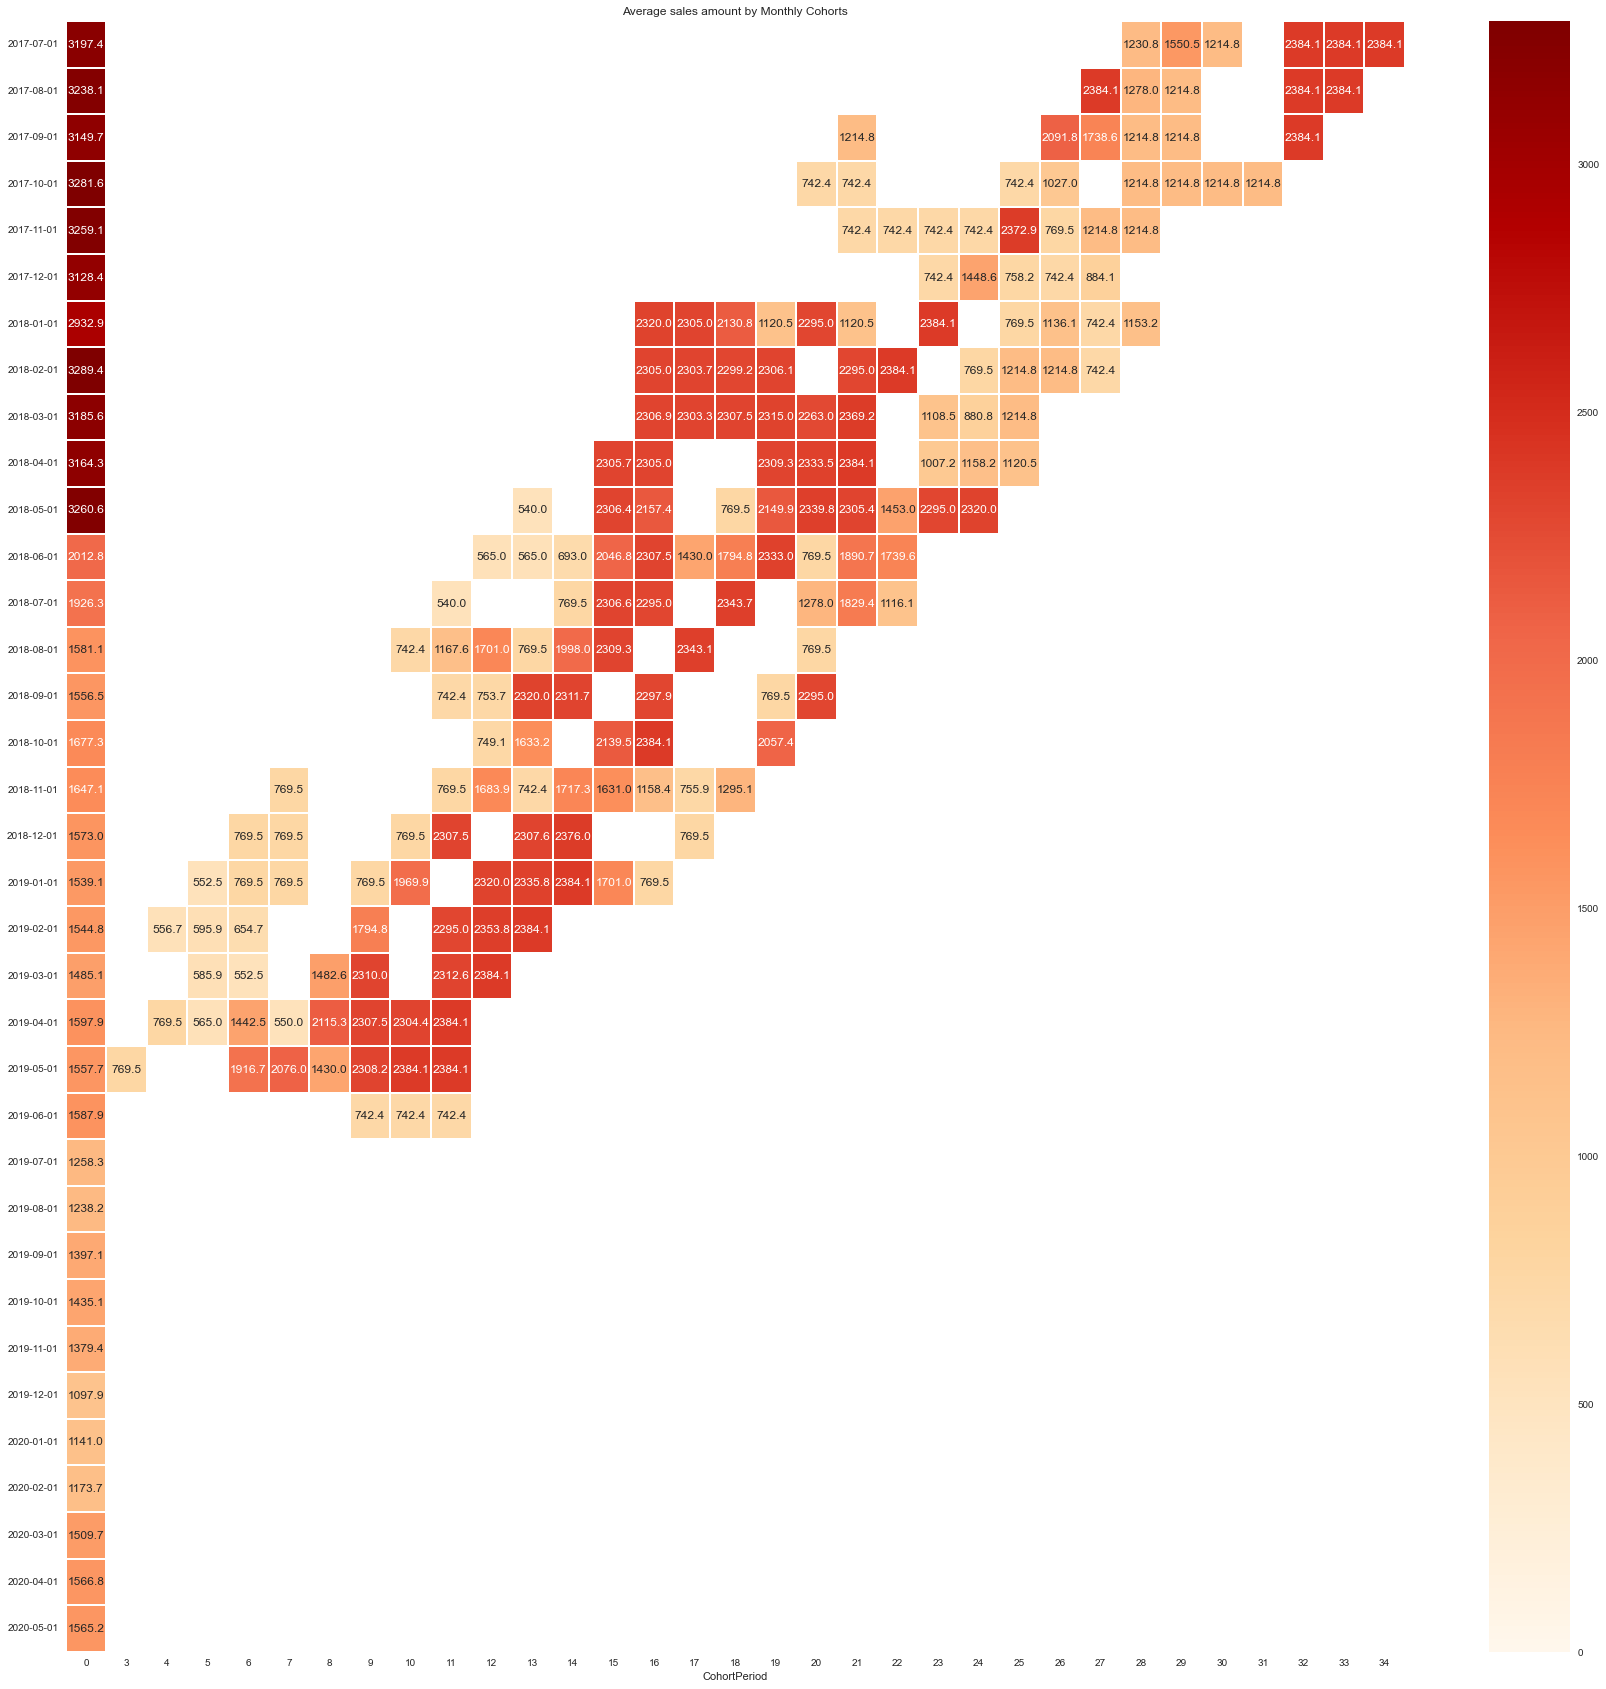

In [95]:
# Initialize inches plot figure
plt.figure(figsize=(30,30))

# Add a title
plt.title('Average sales amount by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data=amount_cohort,
            annot = True,
            cmap = "OrRd",
            vmin = 0.0,
            fmt = '.1f',
            linewidth = 0.3,)
plt.show()

#### Average order quantity by Monthly Cohorts

In [96]:
order_cohort = df_cohort.pivot_table(index='CohortMonth', columns='CohortPeriod', values='SalesOrderLineKey', aggfunc='mean')
order_cohort.index = pd.to_datetime(order_cohort.index).date

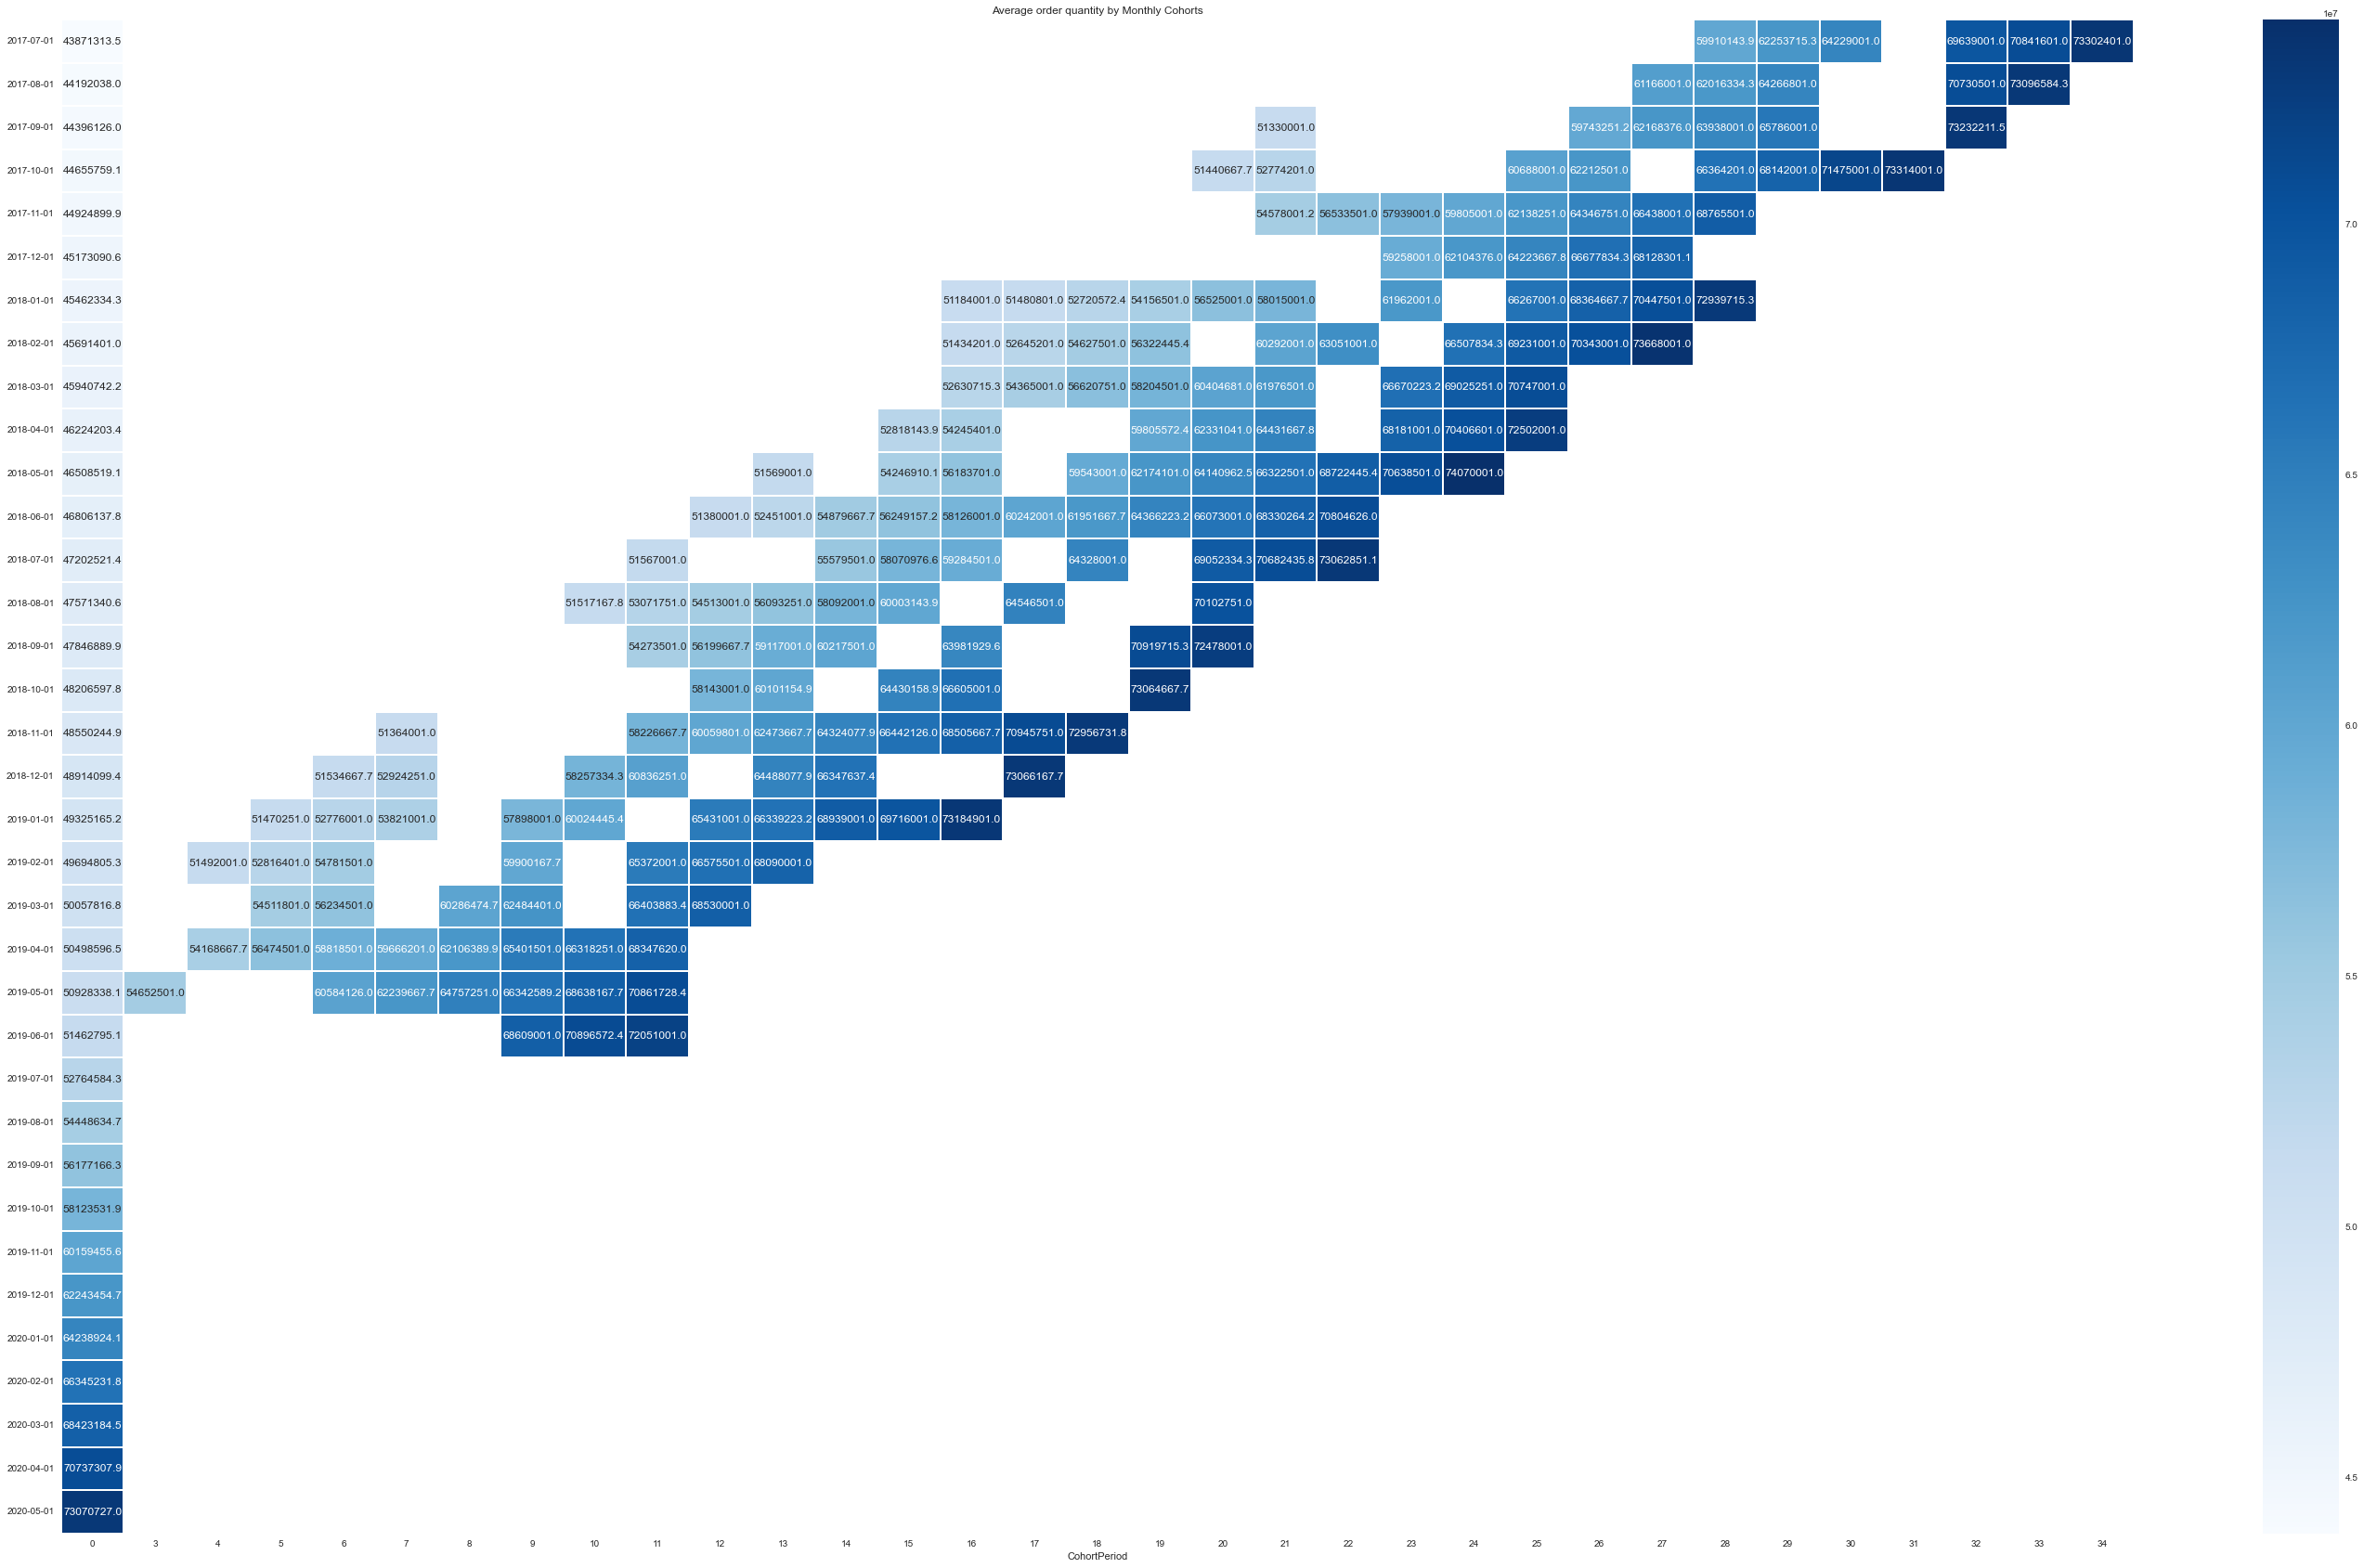

In [97]:
plt.figure(figsize=(50,30))
plt.title('Average order quantity by Monthly Cohorts')
sns.heatmap(data=order_cohort,
            annot = True,
            cmap = "Blues",
            linewidth = 0.3,
            fmt='.1f'
            )

plt.show()